In [52]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import requests

#### Configuration

In [53]:
START_DATE = '2018-01-01' # Captures 2018 Volmageddon, 2020 Covid, 2022 Inflation
END_DATE = dt.datetime.today().strftime('%Y-%m-%d')
ROLLING_WINDOW_SHORT = 21  # ~1 Month Trading Days
ROLLING_WINDOW_LONG = 63   # ~1 Quarter Trading Days

#### STEP 1: UNIVERSE GENERATION

In [54]:
def get_sp500_tickers():
    """Scrapes Wikipedia for the current S&P 500 composition and GICS sectors."""
    url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
    
    # FIX: Define headers to mimic a web browser
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
    }

    try:
        # Pass the headers to the request
        response = requests.get(url, headers=headers)
        response.raise_for_status() 
        
        tables = pd.read_html(response.text)
        df = tables[0]
        
        # Clean ticker symbols
        df['Symbol'] = df['Symbol'].str.replace('.', '-', regex=False)
        
        return df[['Symbol', 'GICS Sector', 'GICS Sub-Industry']]
        
    except Exception as e:
        print(f"Error scraping Wikipedia: {e}")
        return pd.DataFrame()

# Main execution
print("Fetching S&P 500 Constituent List...")
sp500_meta = get_sp500_tickers()

if not sp500_meta.empty:
    tickers = sp500_meta['Symbol'].tolist()
    print(f"Found {len(tickers)} tickers.")
    print(sp500_meta.head())
else:
    print("Failed to retrieve data.")

Fetching S&P 500 Constituent List...
Found 503 tickers.
  Symbol             GICS Sector               GICS Sub-Industry
0    MMM             Industrials        Industrial Conglomerates
1    AOS             Industrials               Building Products
2    ABT             Health Care           Health Care Equipment
3   ABBV             Health Care                   Biotechnology
4    ACN  Information Technology  IT Consulting & Other Services


/var/folders/07/pw5b8gp16d57ynvrzkg2jvdc0000gn/T/ipykernel_29630/4067888673.py:15: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  tables = pd.read_html(response.text)


#### STEP 2: DATA INGESTION (BATCH DOWNLOAD)

In [55]:
# We download everything in one batch for speed
print("Downloading Market Data (Equities + VIX + TNX)...")
# Adding ^VIX (Volatility) and ^TNX (10-Year Treasury Yield) to the download list
all_tickers = tickers + ['^VIX', '^TNX', 'SPY'] 
data = yf.download(all_tickers, start=START_DATE, end=END_DATE, group_by='ticker', auto_adjust=True)

# Separate close prices
close_prices = pd.DataFrame()
for ticker in all_tickers:
    try:
        if ticker in data.columns.levels[0]:
            close_prices[ticker] = data[ticker]['Close']
    except KeyError:
        continue

# Drop tickers with too much missing data (survivorship bias is a known limitation here, but acceptable for this scope)
close_prices.dropna(axis=1, thresh=int(len(close_prices)*0.9), inplace=True)
print(f"Data Download Complete. Shape: {close_prices.shape}")

[*********************100%***********************]  506 of 506 completed


Data Download Complete. Shape: (2022, 480)


/var/folders/07/pw5b8gp16d57ynvrzkg2jvdc0000gn/T/ipykernel_29630/1012079212.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  close_prices[ticker] = data[ticker]['Close']
/var/folders/07/pw5b8gp16d57ynvrzkg2jvdc0000gn/T/ipykernel_29630/1012079212.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  close_prices[ticker] = data[ticker]['Close']
/var/folders/07/pw5b8gp16d57ynvrzkg2jvdc0000gn/T/ipykernel_29630/1012079212.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.inser

#### STEP 3: FEATURE ENGINEERING (RISK METRICS)

In [56]:
print("Calculating Risk Metrics...")

# 1. Log Returns (More statistically stationary than simple returns)
log_returns = np.log(close_prices / close_prices.shift(1))

# 2. Rolling Volatility (Annualized)
# We calculate this for every stock. This is crucial for "Clustering Volatility" later.
rolling_vol_21 = log_returns.rolling(window=ROLLING_WINDOW_SHORT).std() * np.sqrt(252)
rolling_vol_63 = log_returns.rolling(window=ROLLING_WINDOW_LONG).std() * np.sqrt(252)

print("Risk Metrics Calculated.")

# 3. Macro State Variables (Clean up VIX and TNX)
macro_data = pd.DataFrame()
macro_data['VIX'] = close_prices['^VIX']
macro_data['10Y_Yield'] = close_prices['^TNX']
macro_data['SPY_Return'] = log_returns['SPY']

Calculating Risk Metrics...
Risk Metrics Calculated.


In [57]:
# Drop indices from the equity dataframes to keep them pure
equity_cols = [c for c in log_returns.columns if c not in ['^VIX', '^TNX', 'SPY']]
equity_log_returns = log_returns[equity_cols]
equity_rolling_vol = rolling_vol_21[equity_cols]

print("Feature Engineering Complete.")

Feature Engineering Complete.


#### STEP 4: SECTOR AGGREGATION & VISUALIZATION

In [58]:
# Map tickers to sectors in the return dataframe
sector_map = sp500_meta.set_index('Symbol')['GICS Sector'].to_dict()

# Create a melted dataframe for plotting
# We take the latest 21-day volatility snapshot
latest_vol = equity_rolling_vol.iloc[-1].reset_index()
latest_vol.columns = ['Symbol', 'Volatility']
latest_vol['Sector'] = latest_vol['Symbol'].map(sector_map)

# Remove any tickers that didn't map (or were dropped)
latest_vol = latest_vol.dropna()

# Calculate Sector Average Volatility
sector_vol = latest_vol.groupby('Sector')['Volatility'].median().sort_values(ascending=False)

/var/folders/07/pw5b8gp16d57ynvrzkg2jvdc0000gn/T/ipykernel_29630/514983693.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Volatility', y='Sector', data=latest_vol, order=sector_vol.index, palette="viridis")


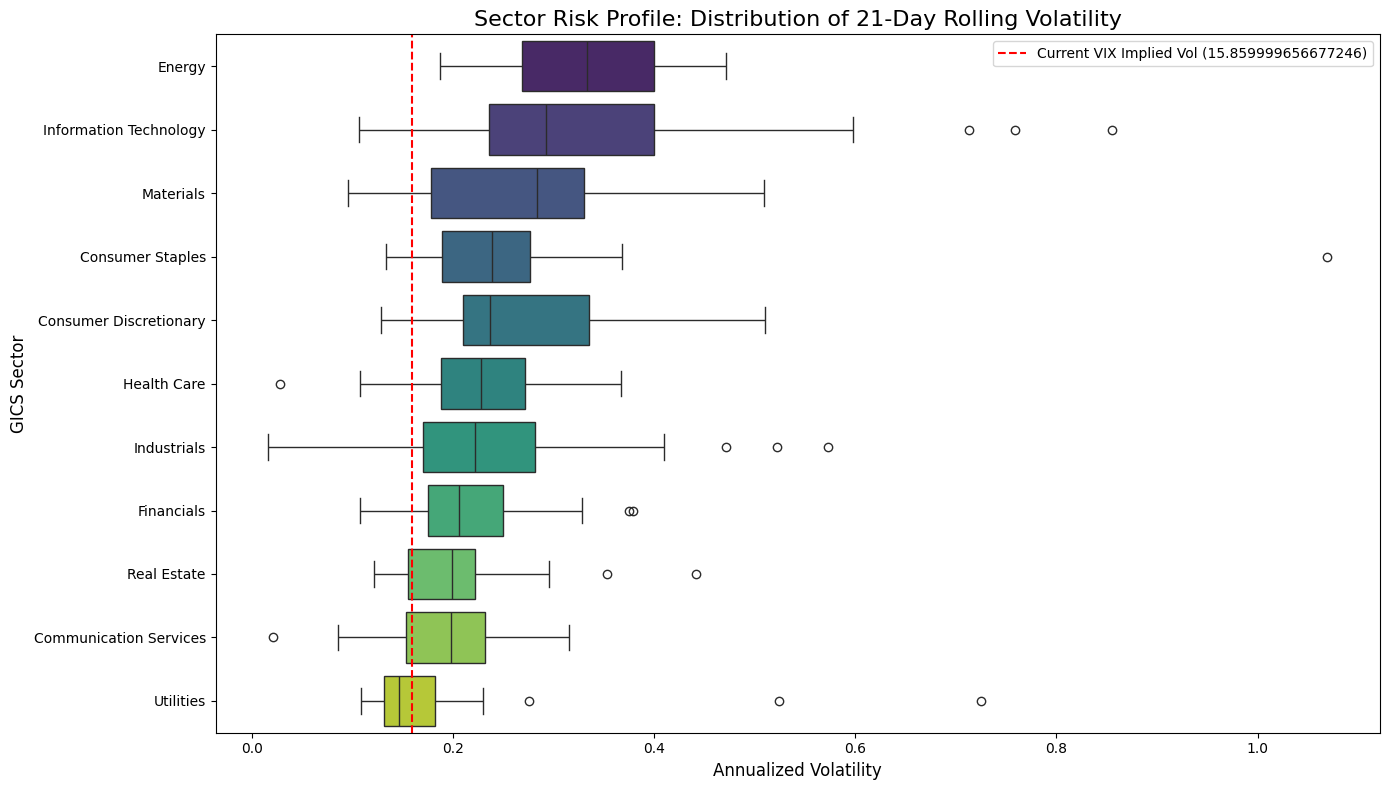

In [59]:
# PLOT 1: Risk Distribution by Sector (Boxplot)
plt.figure(figsize=(14, 8))
sns.boxplot(x='Volatility', y='Sector', data=latest_vol, order=sector_vol.index, palette="viridis")
plt.title(f"Sector Risk Profile: Distribution of {ROLLING_WINDOW_SHORT}-Day Rolling Volatility", fontsize=16)
plt.xlabel("Annualized Volatility", fontsize=12)
plt.ylabel("GICS Sector", fontsize=12)
plt.axvline(x=macro_data['VIX'].iloc[-1]/100, color='r', linestyle='--', label=f'Current VIX Implied Vol ({macro_data["VIX"].iloc[-1]})')
plt.legend()
plt.tight_layout()
plt.show()

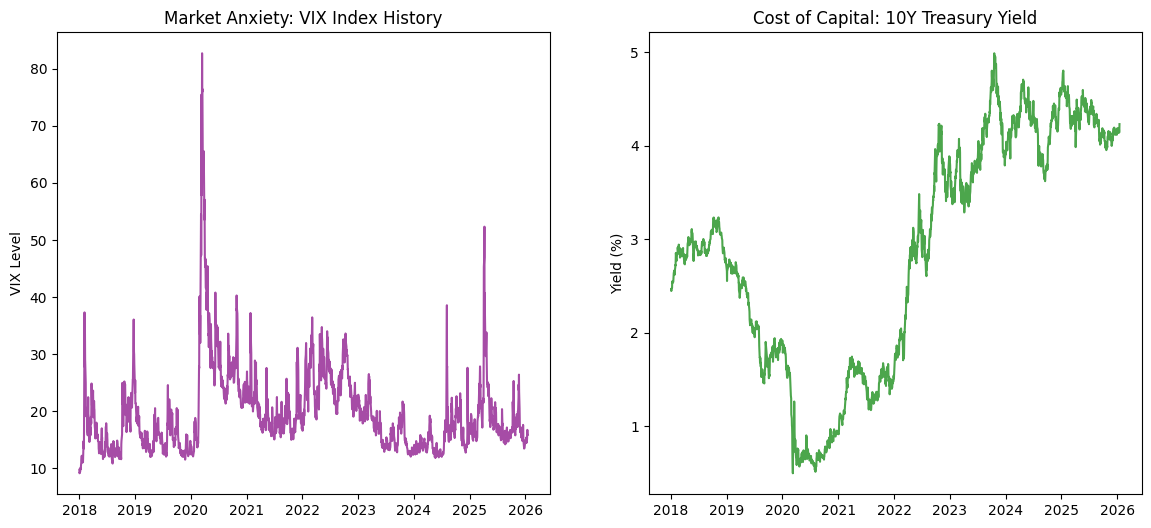

In [60]:
# PLOT 2: The Macro Regime State (VIX vs Yields)
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(macro_data['VIX'], color='purple', alpha=0.7)
plt.title('Market Anxiety: VIX Index History')
plt.ylabel('VIX Level')

plt.subplot(1, 2, 2)
plt.plot(macro_data['10Y_Yield'], color='green', alpha=0.7)
plt.title('Cost of Capital: 10Y Treasury Yield')
plt.ylabel('Yield (%)')
plt.show()

In [61]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

#### PREPARATION: CLEANING DATA FOR PCA

In [62]:
# We use the 'equity_log_returns' from Day 1
# Drop NaN values created by rolling windows or missing data
pca_data = equity_log_returns.dropna()

In [63]:
# Standardize the returns (mean=0, variance=1)
# This is crucial so high-variance stocks (like NVDA) don't dominate the PCA purely by magnitude
scaler = StandardScaler()
scaled_returns = scaler.fit_transform(pca_data)

#### STEP 1: RUNNING PCA

In [64]:
# We look at the top 10 components
pca = PCA(n_components=10)
pca.fit(scaled_returns)

,"n_components n_components: int, float or 'mle', default=NoneNumber of components to keep.if n_components is not set all components are kept:: n_components == min(n_samples, n_features)If ``n_components == 'mle'`` and ``svd_solver == 'full'``, Minka'sMLE is used to guess the dimension. Use of ``n_components == 'mle'``will interpret ``svd_solver == 'auto'`` as ``svd_solver == 'full'``.If ``0 < n_components < 1`` and ``svd_solver == 'full'``, select thenumber of components such that the amount of variance that needs to beexplained is greater than the percentage specified by n_components.If ``svd_solver == 'arpack'``, the number of components must bestrictly less than the minimum of n_features and n_samples.Hence, the None case results in:: n_components == min(n_samples, n_features) - 1",10
,"copy copy: bool, default=TrueIf False, data passed to fit are overwritten and runningfit(X).transform(X) will not yield the expected results,use fit_transform(X) instead.",True
,"whiten whiten: bool, default=FalseWhen True (False by default) the `components_` vectors are multipliedby the square root of n_samples and then divided by the singular valuesto ensure uncorrelated outputs with unit component-wise variances.Whitening will remove some information from the transformed signal(the relative variance scales of the components) but can sometimeimprove the predictive accuracy of the downstream estimators bymaking their data respect some hard-wired assumptions.",False
,"svd_solver svd_solver: {'auto', 'full', 'covariance_eigh', 'arpack', 'randomized'}, default='auto'""auto"" : The solver is selected by a default 'auto' policy is based on `X.shape` and `n_components`: if the input data has fewer than 1000 features and more than 10 times as many samples, then the ""covariance_eigh"" solver is used. Otherwise, if the input data is larger than 500x500 and the number of components to extract is lower than 80% of the smallest dimension of the data, then the more efficient ""randomized"" method is selected. Otherwise the exact ""full"" SVD is computed and optionally truncated afterwards.""full"" : Run exact full SVD calling the standard LAPACK solver via `scipy.linalg.svd` and select the components by postprocessing""covariance_eigh"" : Precompute the covariance matrix (on centered data), run a classical eigenvalue decomposition on the covariance matrix typically using LAPACK and select the components by postprocessing. This solver is very efficient for n_samples >> n_features and small n_features. It is, however, not tractable otherwise for large n_features (large memory footprint required to materialize the covariance matrix). Also note that compared to the ""full"" solver, this solver effectively doubles the condition number and is therefore less numerical stable (e.g. on input data with a large range of singular values).""arpack"" : Run SVD truncated to `n_components` calling ARPACK solver via `scipy.sparse.linalg.svds`. It requires strictly `0 < n_components < min(X.shape)`""randomized"" : Run randomized SVD by the method of Halko et al... versionadded:: 0.18.0.. versionchanged:: 1.5 Added the 'covariance_eigh' solver.",'auto'
,"tol tol: float, default=0.0Tolerance for singular values computed by svd_solver == 'arpack'.Must be of range [0.0, infinity)... versionadded:: 0.18.0",0.0
,"iterated_power iterated_power: int or 'auto', default='auto'Number of iterations for the power method computed bysvd_solver == 'randomized'.Must be of range [0, infinity)... versionadded:: 0.18.0",'auto'
,"n_oversamples n_oversamples: int, default=10This parameter is only relevant when `svd_solver=""randomized""`.It corresponds to the additional number of random vectors to sample therange of `X` so as to ensure proper conditioning. See:func:`~sklearn.utils.extmath.randomized_svd` for more details... versionadded:: 1.1",10
,"power_iteration_normalizer power_iteration_normalizer: {'auto', 'QR', 'LU', 'none'}, default='auto'Power iteration normalizer for randomized SVD

#### STEP 2: ANALYZING EXPLAINED VARIANCE (THE SCREE PLOT)

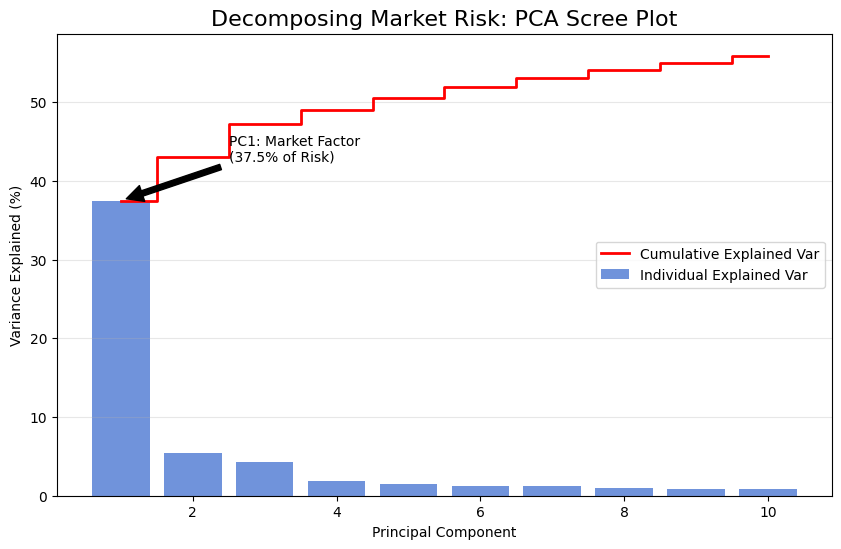

In [65]:
explained_variance = pca.explained_variance_ratio_ * 100
cumulative_variance = np.cumsum(explained_variance)

plt.figure(figsize=(10, 6))
bars = plt.bar(range(1, 11), explained_variance, alpha=0.7, color='#3366cc', label='Individual Explained Var')
plt.step(range(1, 11), cumulative_variance, where='mid', color='red', linewidth=2, label='Cumulative Explained Var')

# Annotation for PC1
plt.annotate(f'PC1: Market Factor\n({explained_variance[0]:.1f}% of Risk)', 
             xy=(1, explained_variance[0]), 
             xytext=(2.5, explained_variance[0]+5),
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.title('Decomposing Market Risk: PCA Scree Plot', fontsize=16)
plt.ylabel('Variance Explained (%)')
plt.xlabel('Principal Component')
plt.legend(loc='center right')
plt.grid(axis='y', alpha=0.3)
plt.show()

#### STEP 3: VISUALIZING MARKET STRUCTURE (PC1 vs PC2)

In [66]:
# Project stocks onto the first two components
pca_components = pca.components_
# Transpose to get (n_stocks, n_components)
loadings = pd.DataFrame(pca_components.T, index=pca_data.columns, columns=[f'PC{i+1}' for i in range(10)])

In [67]:
# Add Sector Labels
loadings['Sector'] = loadings.index.map(sector_map)

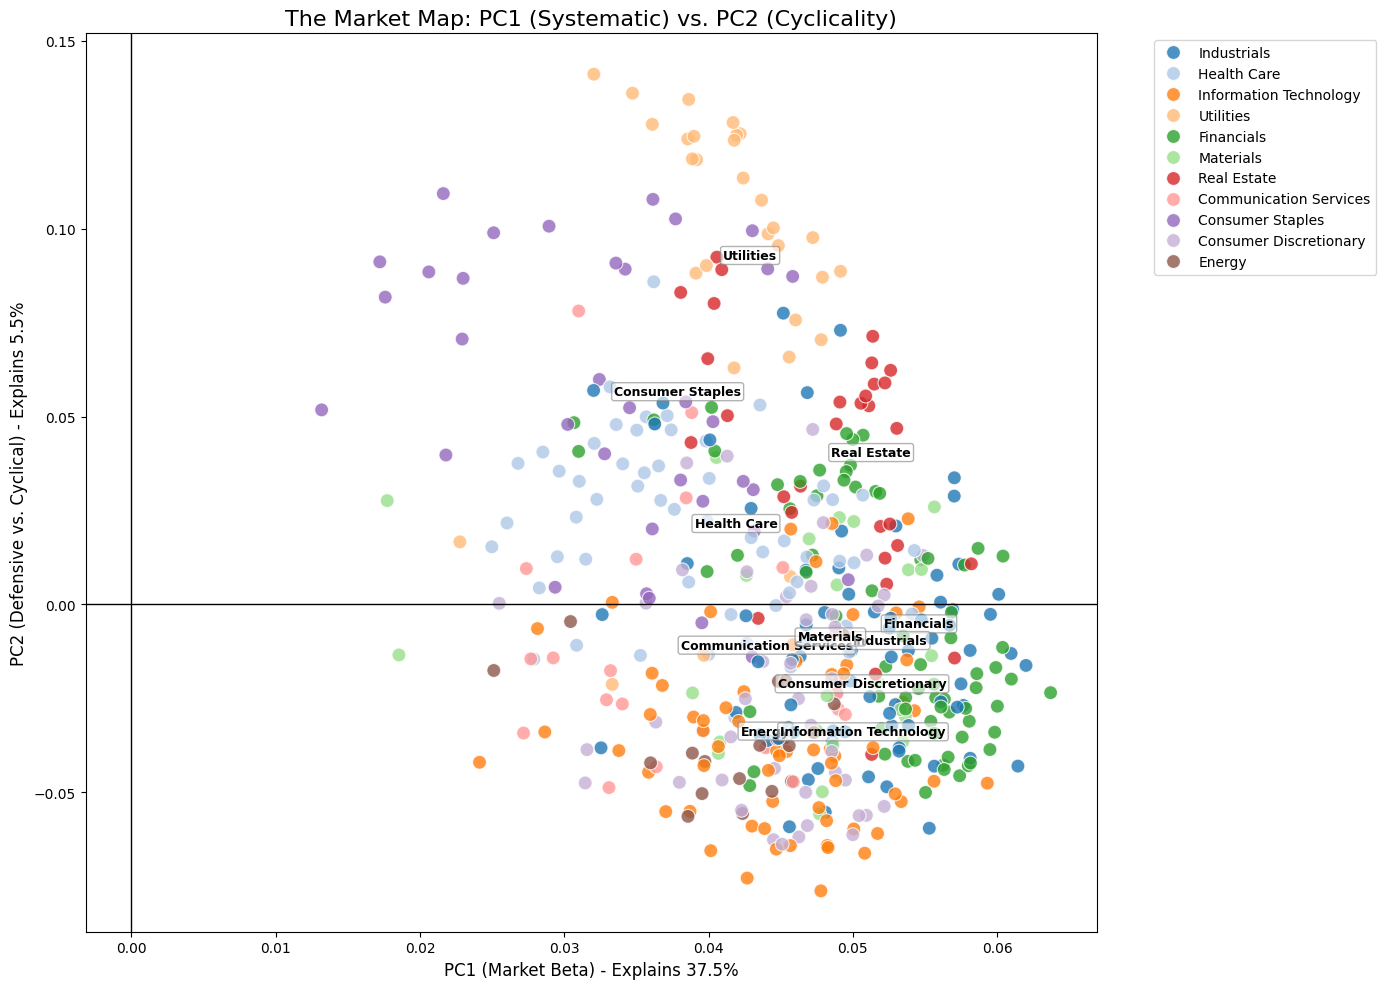

In [68]:
# Plot PC1 vs PC2
plt.figure(figsize=(14, 10))
sns.scatterplot(x='PC1', y='PC2', hue='Sector', data=loadings, palette='tab20', s=100, alpha=0.8)

# Add centroids for each sector (to see the "Average" position)
sector_centroids = loadings.groupby('Sector')[['PC1', 'PC2']].mean()
for sector, row in sector_centroids.iterrows():
    plt.text(row['PC1'], row['PC2'], sector, fontsize=9, weight='bold', 
             bbox=dict(facecolor='white', alpha=0.6, edgecolor='gray', boxstyle='round,pad=0.2'))

plt.title('The Market Map: PC1 (Systematic) vs. PC2 (Cyclicality)', fontsize=16)
plt.xlabel(f'PC1 (Market Beta) - Explains {explained_variance[0]:.1f}%', fontsize=12)
plt.ylabel(f'PC2 (Defensive vs. Cyclical) - Explains {explained_variance[1]:.1f}%', fontsize=12)
plt.axhline(0, color='black', linewidth=1)
plt.axvline(0, color='black', linewidth=1)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [69]:
from sklearn.mixture import GaussianMixture

#### STEP 1: PREPARING THE REGIME DATASET

In [70]:
# We use factors that *define* the market state, not just returns.
regime_data = pd.DataFrame()

# Factor 1: Market Volatility (The "Fear" Gauge)
regime_data['VIX'] = macro_data['VIX']

# Factor 2: Market Momentum (Trend) -> 3-Month Return of SPY
# If Market is Down AND Volatility is High = CRISIS
regime_data['SPY_MOM'] = macro_data['SPY_Return'].rolling(63).sum()

# Factor 3: The Rate Environment (10Y Yield Change)
# This captures the 2022 "Inflation Shock" regime distinct from the 2020 "Deflation Shock"
regime_data['Rates_Chg'] = macro_data['10Y_Yield'].diff(21)

In [71]:
# Drop NaNs created by rolling windows
regime_data.dropna(inplace=True)

In [72]:
# Standardize the data (GMM requires this for stability)
scaler = StandardScaler()
regime_scaled = scaler.fit_transform(regime_data)

#### STEP 2: TRAINING THE REGIME MODEL (GMM)

We force 3 regimes: 
- 0: Likely "Bull/Calm" (Low VIX, Positive Mom)
- 1: Likely "Correction/Inflation" (Med VIX, Rates Rising)
- 2: Likely "Crisis/Crash" (High VIX, Negative Mom)

In [73]:
gmm = GaussianMixture(n_components=3, covariance_type='full', random_state=42)
gmm.fit(regime_scaled)

# Predict the states
regime_labels = gmm.predict(regime_scaled)
regime_probs = gmm.predict_proba(regime_scaled) # Probabilities for each state

# Add back to dataframe
regime_data['Regime'] = regime_labels

In [74]:
# Predict the states
regime_labels = gmm.predict(regime_scaled)
regime_probs = gmm.predict_proba(regime_scaled) # Probabilities for each state

# Add back to dataframe
regime_data['Regime'] = regime_labels

#### STEP 3: ANALYZING THE REGIMES (Which is which?)

In [75]:
# We group by Regime to see the average VIX and Momentum
summary = regime_data.groupby('Regime')[['VIX', 'SPY_MOM']].mean()
print("Regime Characteristics:\n", summary)

# Map labels to human-readable names based on VIX (Highest VIX = Crisis)
# We sort the regimes by VIX level to automate the naming
sorted_regimes = summary.sort_values(by='VIX').index
regime_map = {
    sorted_regimes[0]: 'Calm / Bull',
    sorted_regimes[1]: 'Volatile / Transition',
    sorted_regimes[2]: 'Crisis / Panic'
}
regime_data['Regime_Name'] = regime_data['Regime'].map(regime_map)

print("\nIdentified Regimes based on VIX levels:")
print(regime_map)

Regime Characteristics:
               VIX   SPY_MOM
Regime                     
0       24.731775  0.032315
1       15.901910  0.057163
2       31.280146 -0.108056

Identified Regimes based on VIX levels:
{np.int64(1): 'Calm / Bull', np.int64(0): 'Volatile / Transition', np.int64(2): 'Crisis / Panic'}


#### STEP 4: VISUALIZING THE "TRAFFIC LIGHT"

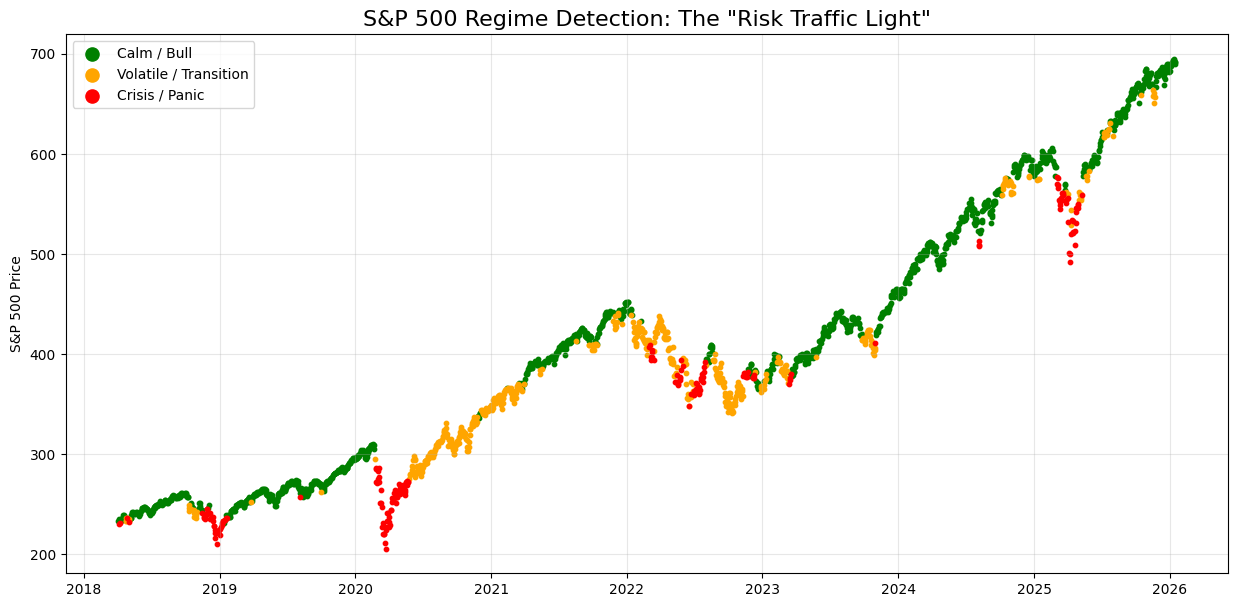

In [76]:
# Plot SPY Price colored by Regime
spy_price = close_prices['SPY'].loc[regime_data.index]

plt.figure(figsize=(15, 7))

# Create a colormap
colors = {'Calm / Bull': 'green', 'Volatile / Transition': 'orange', 'Crisis / Panic': 'red'}

# We plot using scatter to color-code points (efficient for regimes)
# Note: For a continuous line with changing colors, we usually use scatter or broken lines
for regime_name, color in colors.items():
    mask = regime_data['Regime_Name'] == regime_name
    plt.scatter(spy_price.index[mask], spy_price[mask], 
                c=color, label=regime_name, s=10)

plt.title('S&P 500 Regime Detection: The "Risk Traffic Light"', fontsize=16)
plt.ylabel('S&P 500 Price')
plt.legend(markerscale=3)
plt.grid(alpha=0.3)
plt.show()

#### STEP 5: PROBABILITY CHART (The "Risk Manager's View")

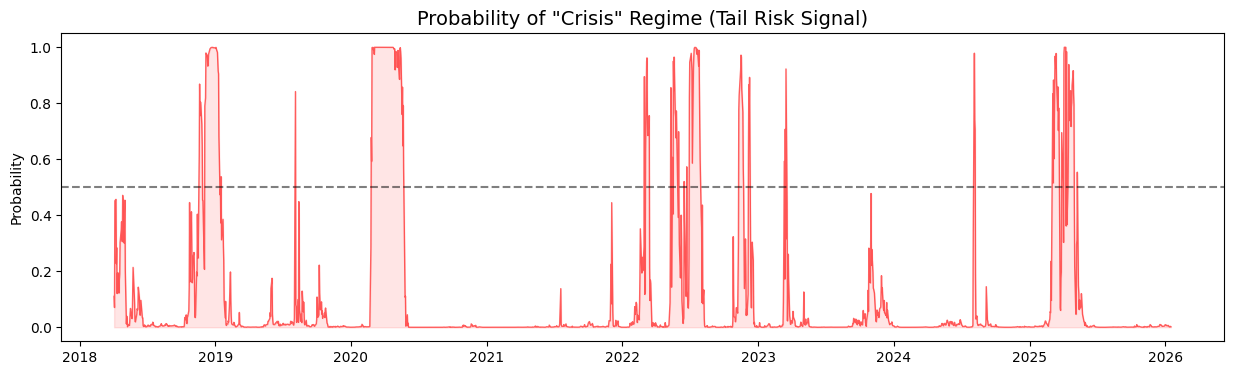

In [77]:
# Plot the probability of being in the "Crisis" state over time
crisis_label = sorted_regimes[2] # The label corresponding to highest VIX
plt.figure(figsize=(15, 4))
plt.plot(regime_data.index, regime_probs[:, crisis_label], color='red', alpha=0.6, linewidth=1)
plt.fill_between(regime_data.index, regime_probs[:, crisis_label], color='red', alpha=0.1)
plt.title('Probability of "Crisis" Regime (Tail Risk Signal)', fontsize=14)
plt.ylabel('Probability')
plt.axhline(0.5, linestyle='--', color='black', alpha=0.5)
plt.show()

#### Step 5: Regime Detection Engine (GMM)

Regime Detection Complete.
Regime Definitions (Average VIX):
Regime
0    15.391754
1    23.850000
2    43.230896
Name: VIX, dtype: float64


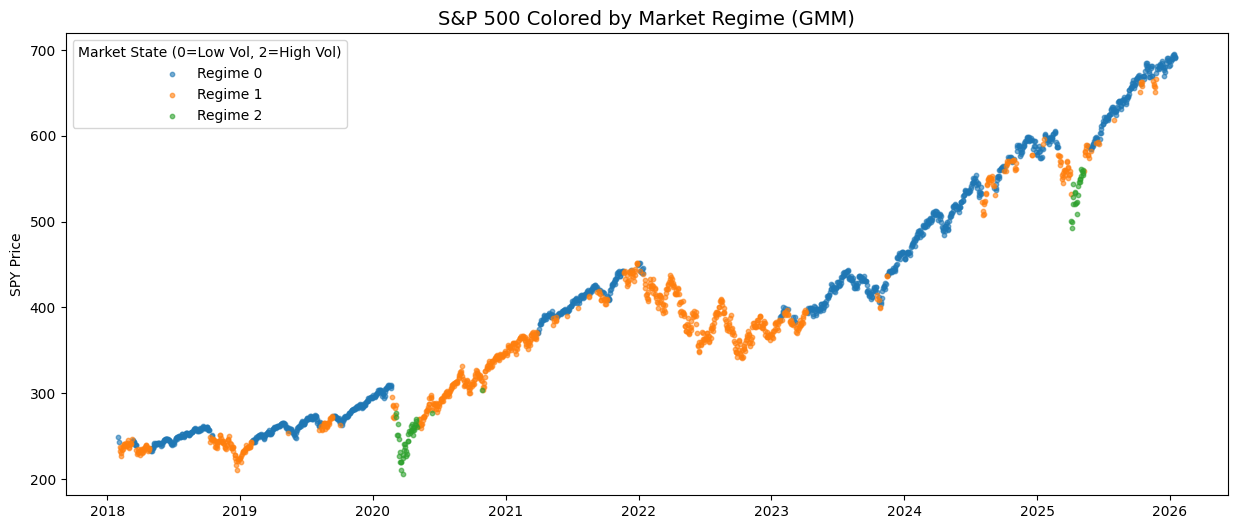

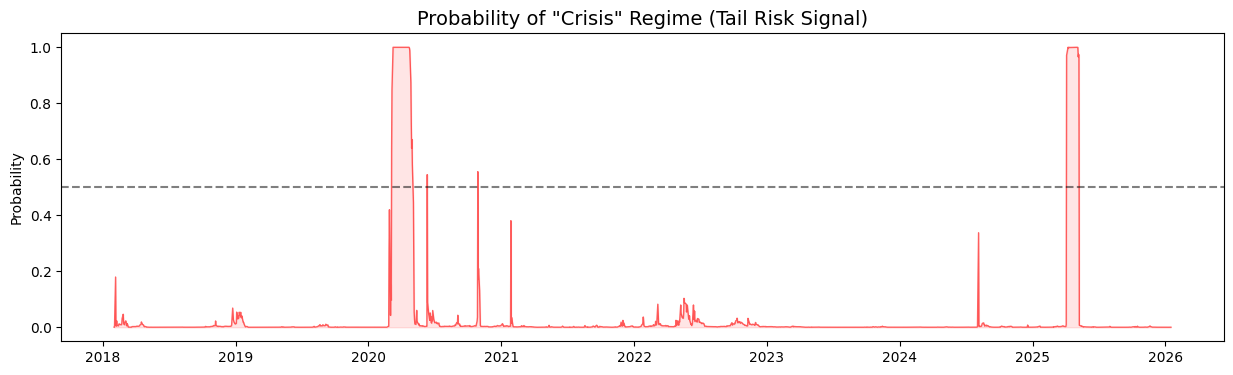

In [79]:
from sklearn.mixture import GaussianMixture

# --- Configuration for Regime Detection ---
# We use VIX (Implied Volatility) and SPY Realized Volatility as our "Regime Drivers"
# You can add '10Y_Yield' to this list if you want interest rate sensitivity.
REGIME_FEATURES = ['VIX', 'SPY_Vol'] 

# Prepare the training data
# We need to calculate SPY's rolling volatility to match our equity features
macro_data['SPY_Vol'] = macro_data['SPY_Return'].rolling(window=21).std() * np.sqrt(252)
dataset = macro_data[REGIME_FEATURES].dropna()

# Fit the Gaussian Mixture Model
# n_components=3 usually captures: 1. Low Vol (Bull), 2. High Vol (Correction), 3. Extreme (Crisis)
gmm = GaussianMixture(n_components=3, covariance_type='full', random_state=42)
gmm.fit(dataset)

# Predict the latent states
regime_labels = gmm.predict(dataset)
dataset['Regime'] = regime_labels

# --- REORDER REGIMES (Crucial Step) ---
# GMM assigns labels (0,1,2) randomly. We want 0=Low Risk, 2=High Risk.
# We sort them based on the average VIX in that regime.
regime_means = dataset.groupby('Regime')['VIX'].mean().sort_values()
reorder_map = {old_label: new_label for new_label, old_label in enumerate(regime_means.index)}
dataset['Regime'] = dataset['Regime'].map(reorder_map)

print("Regime Detection Complete.")
print("Regime Definitions (Average VIX):")
print(dataset.groupby('Regime')['VIX'].mean())

# --- Plotting the Regimes ---
import matplotlib.cm as cm

plt.figure(figsize=(15, 6))
# Create a scatter plot colored by Regime
# We use SPY Price for context, colored by the Regime
spy_price = close_prices['SPY'].loc[dataset.index]

# Create segments for coloring the line
for regime in range(3):
    mask = dataset['Regime'] == regime
    plt.scatter(dataset.index[mask], spy_price[mask], 
                s=10, label=f'Regime {regime}', alpha=0.6)

plt.title('S&P 500 Colored by Market Regime (GMM)', fontsize=14)
plt.ylabel('SPY Price')
plt.legend(title='Market State (0=Low Vol, 2=High Vol)')
plt.show()

# Visualize the Probability of "Crisis" Regime
# We must use dataset[REGIME_FEATURES] to exclude the 'Regime' column we just added
regime_probs = gmm.predict_proba(dataset[REGIME_FEATURES])

# Since we reordered, the last column (index 2) is the High Volatility/Crisis state
crisis_prob = regime_probs[:, reorder_map[regime_means.index[-1]]]

plt.figure(figsize=(15, 4))
plt.plot(dataset.index, crisis_prob, color='red', alpha=0.6, linewidth=1)
plt.fill_between(dataset.index, crisis_prob, color='red', alpha=0.1)
plt.title('Probability of "Crisis" Regime (Tail Risk Signal)', fontsize=14)
plt.ylabel('Probability')
plt.axhline(0.5, linestyle='--', color='black', alpha=0.5)
plt.show()

[*********************100%***********************]  11 of 11 completed


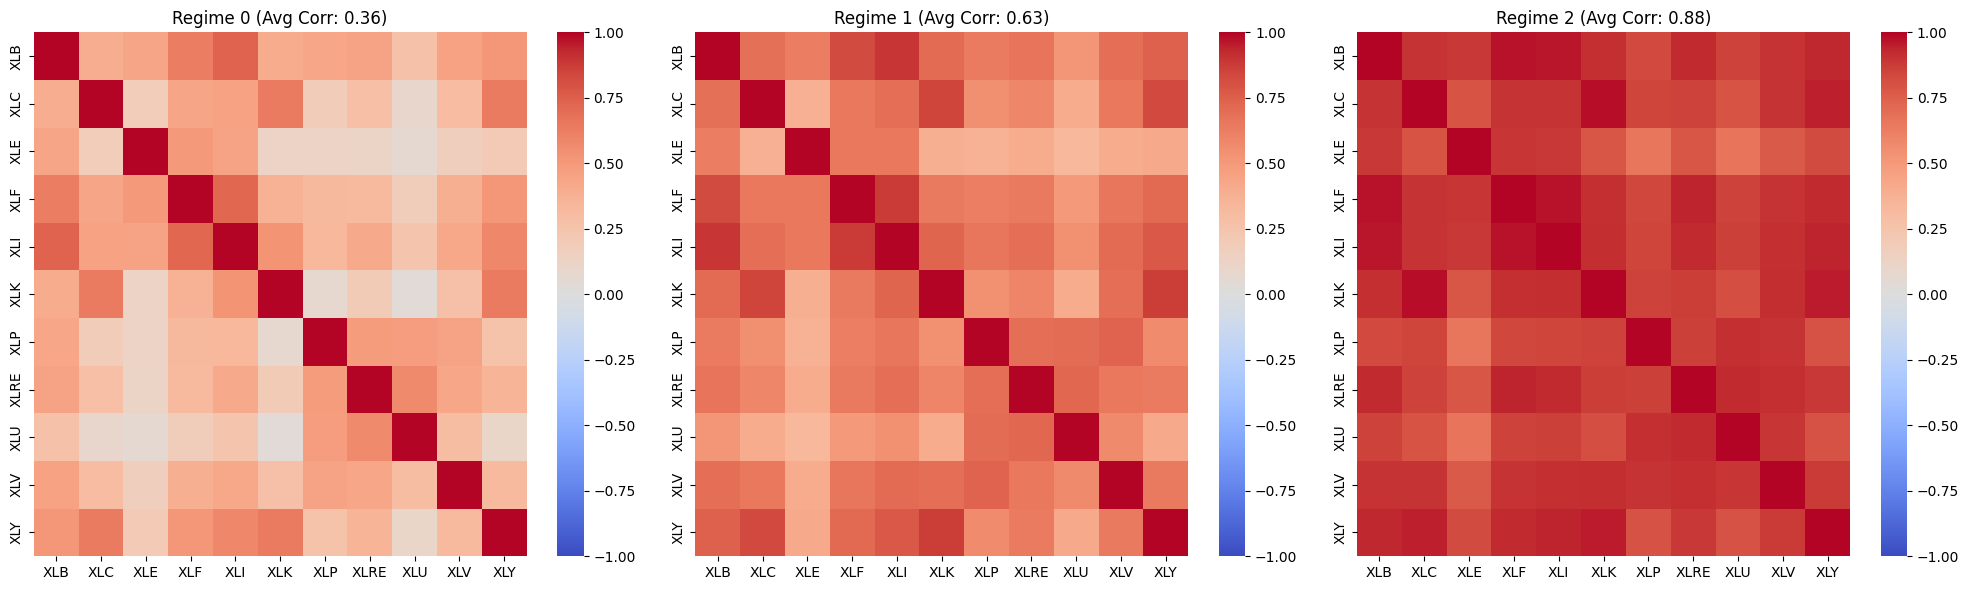

In [83]:
import seaborn as sns

# 1. Fetch Sector ETF Data (The "What")
# We use the standard SPDR Select Sector ETFs to represent the market
sector_tickers = ['XLE', 'XLF', 'XLU', 'XLI', 'XLK', 'XLV', 'XLY', 'XLP', 'XLB', 'XLRE', 'XLC']
sector_data = yf.download(sector_tickers, start=START_DATE, end=END_DATE)['Close']

# Calculate Log Returns for Sectors
sector_returns = np.log(sector_data / sector_data.shift(1)).dropna()

# 2. Merge with Regime Labels
# We align the sector returns with the regime labels from the previous step
# Ensure indices match
aligned_data = sector_returns.join(dataset['Regime'], how='inner')

# 3. Analyze Correlations by Regime
unique_regimes = aligned_data['Regime'].unique()
plt.figure(figsize=(20, 6))

for i, regime in enumerate(sorted(unique_regimes)):
    # Filter data for this specific regime
    regime_subset = aligned_data[aligned_data['Regime'] == regime].drop(columns=['Regime'])
    
    # Calculate Correlation Matrix
    corr_matrix = regime_subset.corr()
    
    # Calculate Average Correlation (a single number to summarize the "tightness" of the market)
    avg_corr = corr_matrix.values[np.triu_indices_from(corr_matrix.values, 1)].mean()
    
    # Plot Heatmap
    plt.subplot(1, 3, i+1)
    sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title(f'Regime {regime} (Avg Corr: {avg_corr:.2f})')

plt.tight_layout()
plt.show()

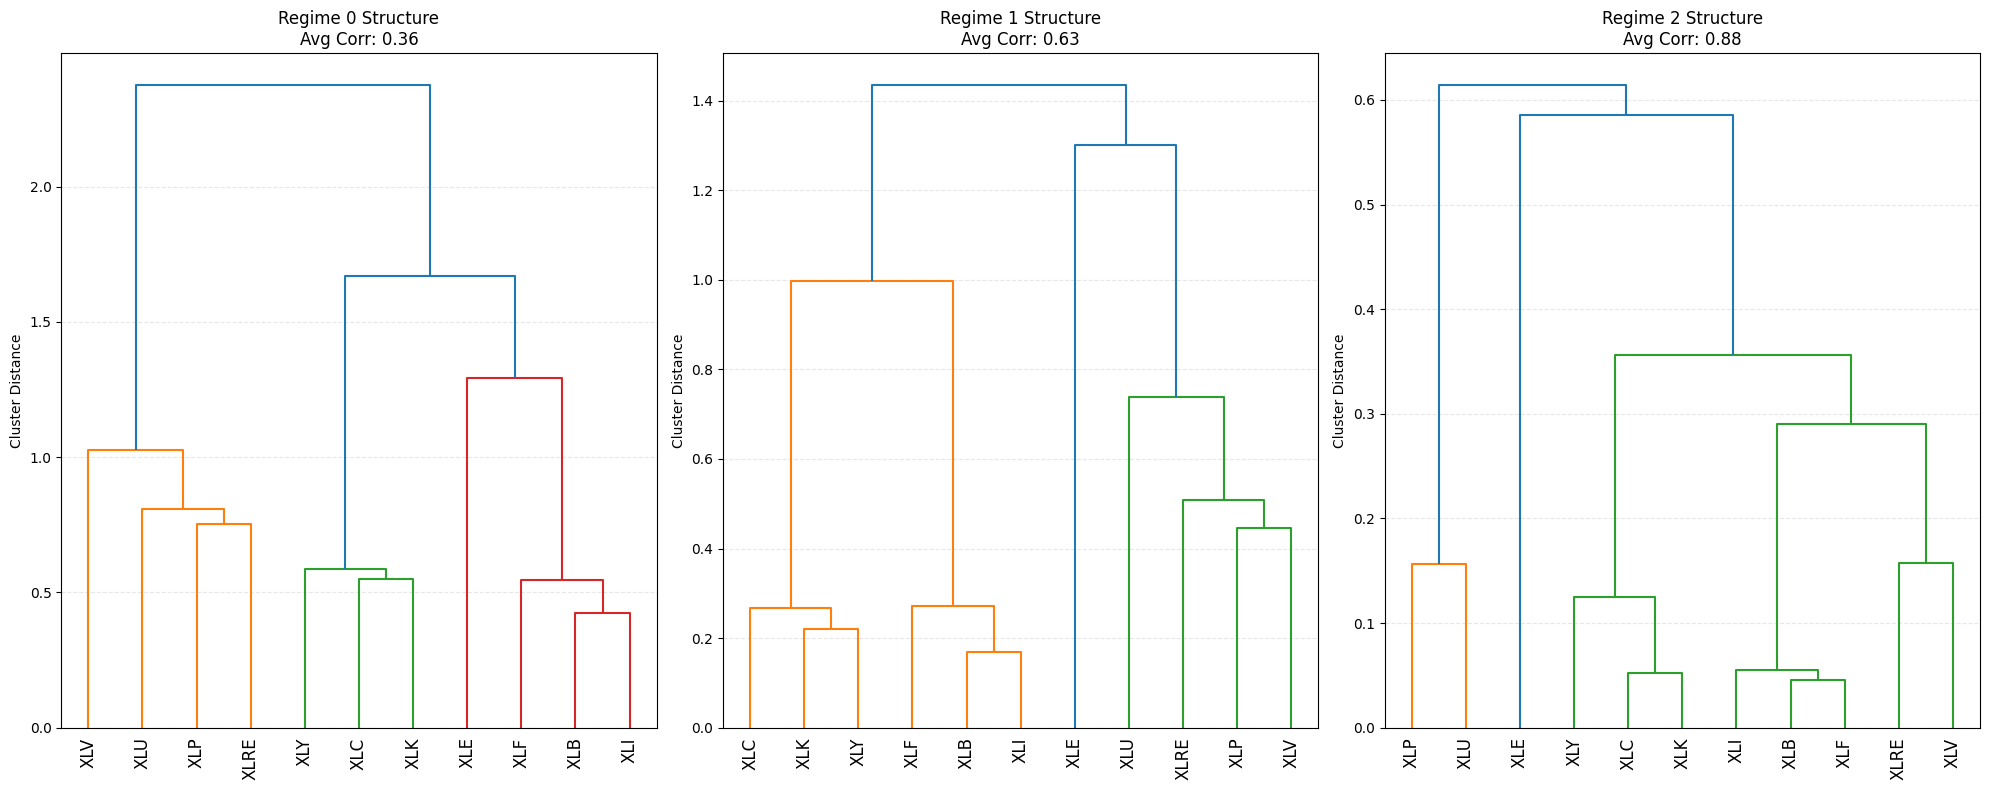

In [85]:
import scipy.cluster.hierarchy as sch

# We use the 'aligned_data' from your previous step
unique_regimes = sorted(aligned_data['Regime'].unique())

plt.figure(figsize=(20, 8))

for i, regime in enumerate(unique_regimes):
    # 1. Filter data for this regime
    regime_subset = aligned_data[aligned_data['Regime'] == regime].drop(columns=['Regime'])
    
    # 2. Calculate Correlation and Distance
    # We convert Correlation to Distance because clustering groups things that are "close" (small distance)
    corr_matrix = regime_subset.corr()
    d = sch.distance.pdist(corr_matrix) 
    L = sch.linkage(d, method='ward') # 'Ward' minimizes variance within clusters
    
    # 3. Plot Dendrogram
    ax = plt.subplot(1, 3, i+1)
    dendrogram = sch.dendrogram(L, labels=corr_matrix.columns, leaf_rotation=90, ax=ax)
    
    # formatting
    avg_corr = corr_matrix.values[np.triu_indices_from(corr_matrix.values, 1)].mean()
    plt.title(f'Regime {regime} Structure\nAvg Corr: {avg_corr:.2f}')
    plt.ylabel('Cluster Distance')
    plt.grid(axis='y', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

Risk Profile by Market Regime:
       Daily VaR (95%) Daily CVaR (95%) Annualized Vol  Count
Regime                                                       
0               -0.84%           -1.19%          9.18%   1060
1               -2.21%           -2.79%         19.61%    778
2               -6.33%           -9.57%         63.79%     67


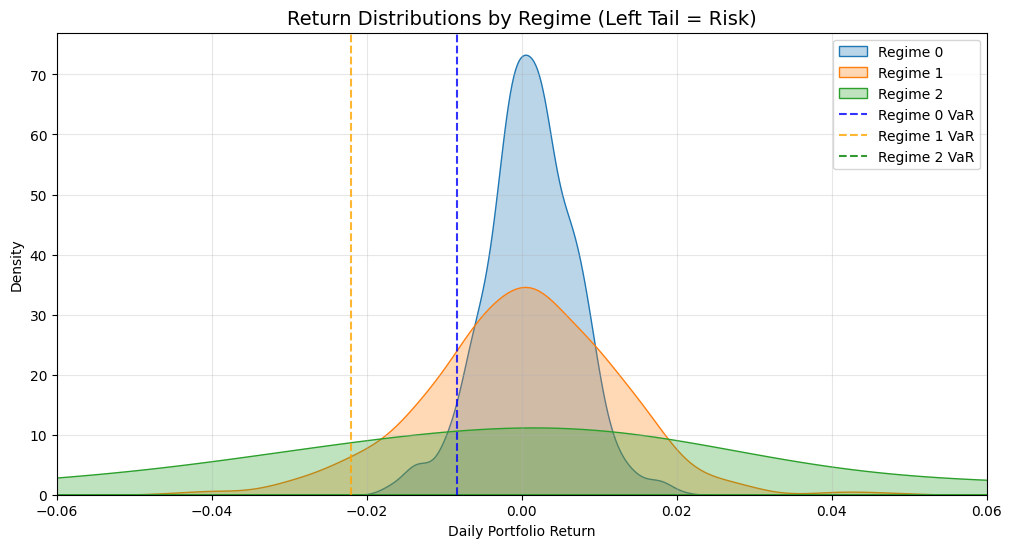

In [86]:
import scipy.stats as stats

# 1. Construct a Hypothetical Portfolio
# We assume an Equal-Weighted portfolio of all 11 sectors
# (In reality, you might strictly hold Low-Vol sectors in Regime 2, but this shows the baseline risk)
portfolio_returns = aligned_data.drop(columns=['Regime']).mean(axis=1)
portfolio_data = pd.DataFrame({'Return': portfolio_returns, 'Regime': aligned_data['Regime']})

# 2. Calculate Risk Metrics by Regime
risk_metrics = []

for regime in sorted(portfolio_data['Regime'].unique()):
    # Filter returns for this regime
    subset = portfolio_data[portfolio_data['Regime'] == regime]['Return']
    
    # Historical VaR (95% Confidence)
    # The 5th percentile of returns (cutoff for the worst 5% of days)
    var_95 = np.percentile(subset, 5)
    
    # Conditional VaR (CVaR) / Expected Shortfall
    # The average of all returns that happened to be WORSE than the VaR
    cvar_95 = subset[subset <= var_95].mean()
    
    risk_metrics.append({
        'Regime': regime,
        'Daily VaR (95%)': f"{var_95:.2%}",
        'Daily CVaR (95%)': f"{cvar_95:.2%}",
        'Annualized Vol': f"{(subset.std() * np.sqrt(252)):.2%}",
        'Count': len(subset)
    })

results_df = pd.DataFrame(risk_metrics).set_index('Regime')
print("Risk Profile by Market Regime:")
print(results_df)

# 3. Visualizing the Shift in Distributions
plt.figure(figsize=(12, 6))

for regime in sorted(portfolio_data['Regime'].unique()):
    subset = portfolio_data[portfolio_data['Regime'] == regime]['Return']
    sns.kdeplot(subset, label=f'Regime {regime}', fill=True, alpha=0.3)

# Add lines for VaR
colors = ['blue', 'orange', 'green'] # Standard seaborn cycle
for i, regime in enumerate(sorted(portfolio_data['Regime'].unique())):
    subset = portfolio_data[portfolio_data['Regime'] == regime]['Return']
    var = np.percentile(subset, 5)
    plt.axvline(var, linestyle='--', alpha=0.8, color=colors[i], label=f'Regime {regime} VaR')

plt.title('Return Distributions by Regime (Left Tail = Risk)', fontsize=14)
plt.xlabel('Daily Portfolio Return')
plt.ylabel('Density')
plt.xlim(-0.06, 0.06) # Zoom in on the center/tails
plt.legend()
plt.grid(alpha=0.3)
plt.show()

Successfully saved 'market_regimes.csv'


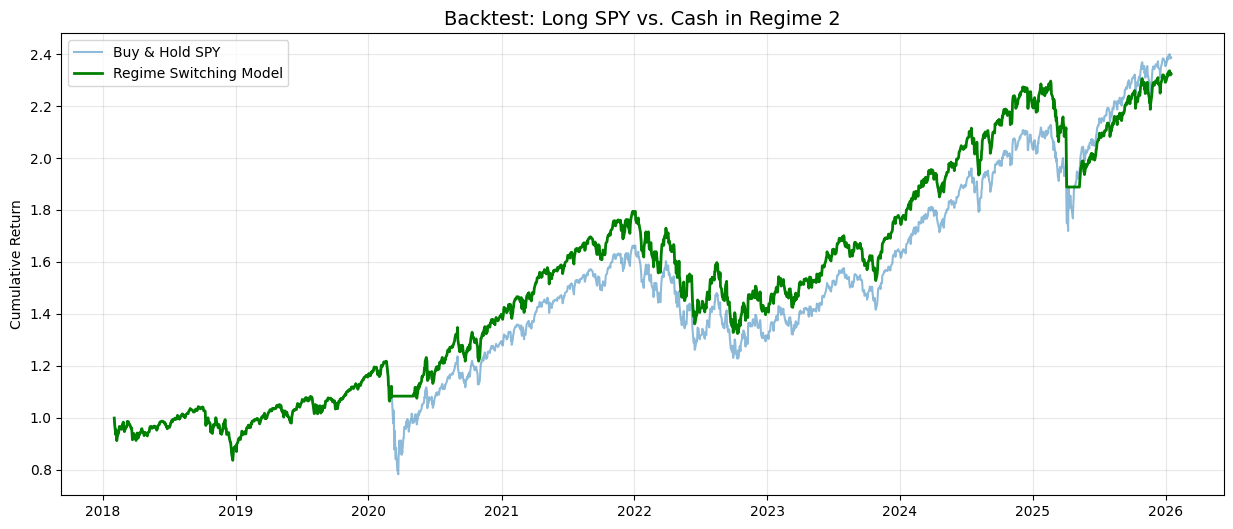

Buy & Hold Total Return: 138.70%
Strategy Total Return:   132.38%


In [87]:
# 1. Save the Regime Data to CSV
# We include Price, Returns, VIX, and the Regime Label
output_df = dataset[['VIX', 'Regime']].copy()
output_df['SPY_Price'] = close_prices['SPY'].loc[dataset.index]
output_df['SPY_Return'] = macro_data['SPY_Return'].loc[dataset.index]

output_df.to_csv('market_regimes.csv')
print("Successfully saved 'market_regimes.csv'")

# 2. Simple Backtest: "The Crisis Avoider"
# Logic: If yesterday was Regime 2 (Crisis), sit in Cash (0% return) today.
# Otherwise, be Long SPY.

# Shift the regime by 1 day to avoid look-ahead bias (we trade tomorrow based on today's close)
output_df['Signal'] = output_df['Regime'].shift(1)

# Apply Strategy: If Signal is 2, Return is 0. Else, Return is SPY_Return.
# (We assume 0% return for Cash, though in reality it would be the Risk-Free Rate)
output_df['Strategy_Return'] = np.where(output_df['Signal'] == 2, 0, output_df['SPY_Return'])

# Calculate Cumulative Returns
output_df['Buy_and_Hold'] = (1 + output_df['SPY_Return']).cumprod()
output_df['Regime_Model'] = (1 + output_df['Strategy_Return']).cumprod()

# Plot the Result
plt.figure(figsize=(15, 6))
plt.plot(output_df.index, output_df['Buy_and_Hold'], label='Buy & Hold SPY', alpha=0.5)
plt.plot(output_df.index, output_df['Regime_Model'], label='Regime Switching Model', color='green', linewidth=2)

plt.title('Backtest: Long SPY vs. Cash in Regime 2', fontsize=14)
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Performance Stats
bh_ret = output_df['Buy_and_Hold'].iloc[-1] - 1
strat_ret = output_df['Regime_Model'].iloc[-1] - 1
print(f"Buy & Hold Total Return: {bh_ret:.2%}")
print(f"Strategy Total Return:   {strat_ret:.2%}")

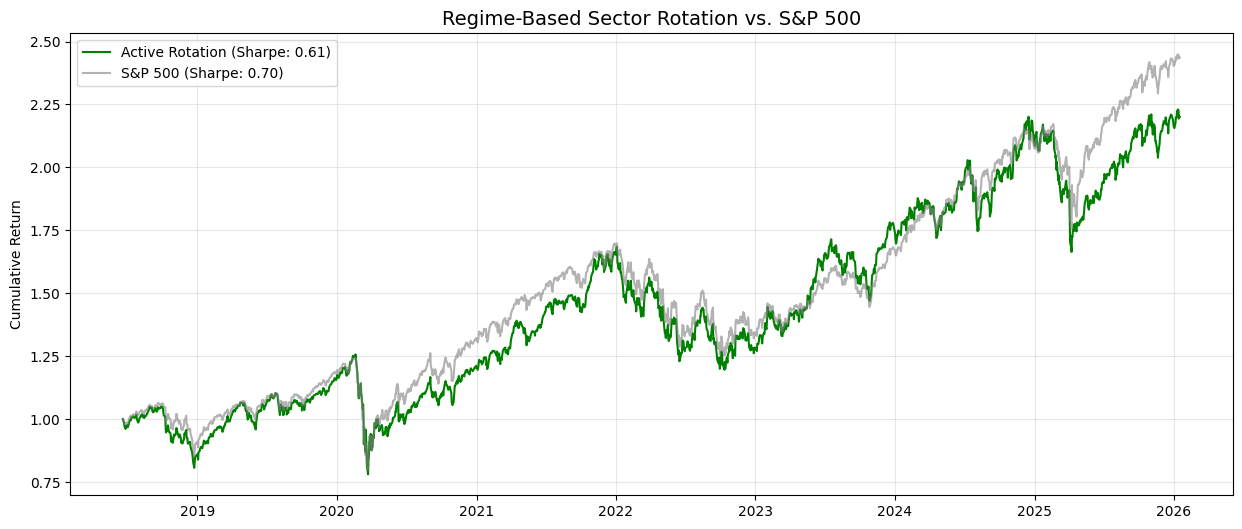

Strategy Max Drawdown: -37.89%
S&P 500 Max Drawdown:  -35.75%


In [90]:
# --- CORRECTED STEP 10: Dynamic Sector Rotation ---

# 1. Define the Strategy Baskets
regime_map = {
    0: ['XLK', 'XLY'],  # Bull Market: Tech + Discretionary
    1: ['SPY'],         # Neutral: Broad Market
    2: ['XLU', 'XLP']   # Crisis: Utilities + Staples
}

# 2. ALIGN DATA (The Fix)
# We find the dates that exist in BOTH dataset and sector_returns
valid_dates = dataset.index.intersection(sector_returns.index)

# Filter both dataframes to only these valid dates
aligned_dataset = dataset.loc[valid_dates]
aligned_sectors = sector_returns.loc[valid_dates]
aligned_macro = macro_data.loc[valid_dates] # Ensure macro data aligns too

# 3. Vectorized Backtest Engine
backtest = pd.DataFrame(index=valid_dates)
backtest['Regime_Signal'] = aligned_dataset['Regime'].shift(1) # Trade on yesterday's signal

active_returns = []

# Loop over the ALIGNED index
for date, row in backtest.iterrows():
    signal = row['Regime_Signal']
    
    # Handle NaN at the start (first day has no previous day signal)
    if pd.isna(signal):
        active_returns.append(0.0)
        continue
        
    # Get the basket for today's regime
    basket = regime_map[int(signal)]
    
    # Calculate the equal-weighted return of the basket for today
    daily_rets = []
    for ticker in basket:
        if ticker == 'SPY':
            daily_rets.append(aligned_macro.loc[date, 'SPY_Return'])
        else:
            daily_rets.append(aligned_sectors.loc[date, ticker])
            
    # Portfolio return is the average of the basket constituents
    active_returns.append(np.mean(daily_rets))

backtest['Strategy_Return'] = active_returns
backtest['SPY_Return'] = aligned_macro['SPY_Return']

# 4. Performance Metrics
backtest['Strategy_Equity'] = (1 + backtest['Strategy_Return']).cumprod()
backtest['SPY_Equity'] = (1 + backtest['SPY_Return']).cumprod()

strat_sharpe = (backtest['Strategy_Return'].mean() / backtest['Strategy_Return'].std()) * np.sqrt(252)
spy_sharpe = (backtest['SPY_Return'].mean() / backtest['SPY_Return'].std()) * np.sqrt(252)

# Calculate Max Drawdown
def get_max_drawdown(equity_curve):
    rolling_max = equity_curve.cummax()
    drawdown = (equity_curve - rolling_max) / rolling_max
    return drawdown.min()

strat_dd = get_max_drawdown(backtest['Strategy_Equity'])
spy_dd = get_max_drawdown(backtest['SPY_Equity'])

# 5. Visualization
plt.figure(figsize=(15, 6))
plt.plot(backtest.index, backtest['Strategy_Equity'], label=f'Active Rotation (Sharpe: {strat_sharpe:.2f})', color='green')
plt.plot(backtest.index, backtest['SPY_Equity'], label=f'S&P 500 (Sharpe: {spy_sharpe:.2f})', color='gray', alpha=0.6)

plt.title('Regime-Based Sector Rotation vs. S&P 500', fontsize=14)
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

print(f"Strategy Max Drawdown: {strat_dd:.2%}")
print(f"S&P 500 Max Drawdown:  {spy_dd:.2%}")

Original Strategy Drawdown: -37.89%
Smoothed Strategy Drawdown: -40.27%


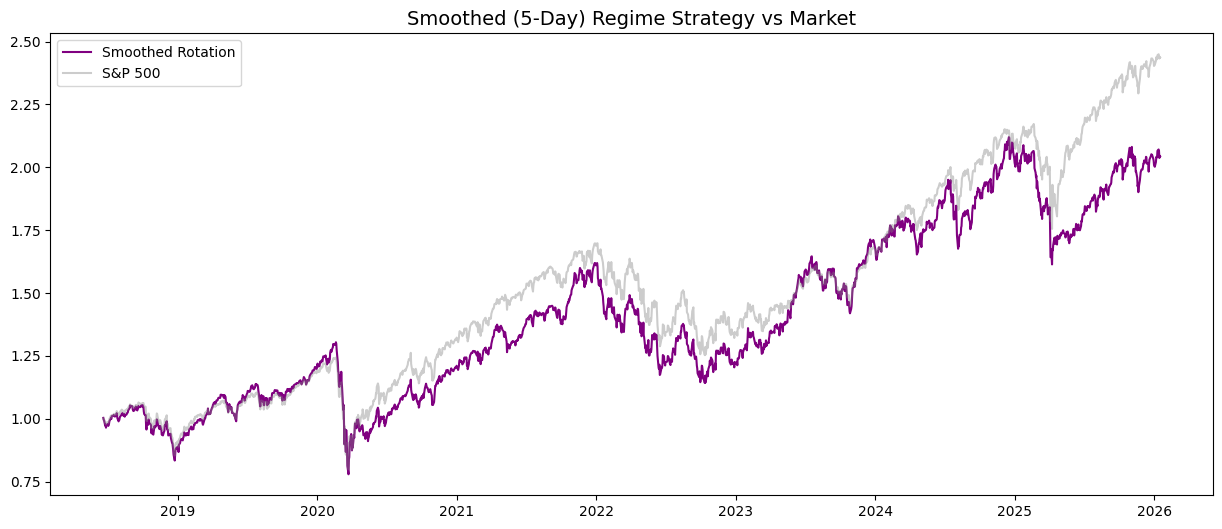

In [91]:
from scipy import stats

# 1. Apply Smoothing (The "Patience" Filter)
# We use a rolling window to find the "Mode" (most frequent) regime over the last 5 days.
# This prevents the model from reacting to single-day freakouts.
window_size = 5
smoothed_regimes = dataset['Regime'].rolling(window=window_size).apply(lambda x: stats.mode(x, keepdims=True)[0][0]).dropna()

# Align the smoothed signal
# Note: We must shift by 1 again because we trade 'tomorrow' based on the smoothed signal of 'today'
backtest_smooth = pd.DataFrame(index=smoothed_regimes.index)
backtest_smooth['Regime_Signal'] = smoothed_regimes.shift(1)

# 2. Re-Run Vectorized Backtest with Smoothed Signal
active_returns_smooth = []

# Align Data again for the new index
valid_dates_smooth = backtest_smooth.index.intersection(aligned_sectors.index)
backtest_smooth = backtest_smooth.loc[valid_dates_smooth]
aligned_macro_smooth = macro_data.loc[valid_dates_smooth]
aligned_sectors_smooth = sector_returns.loc[valid_dates_smooth]

for date, row in backtest_smooth.iterrows():
    signal = row['Regime_Signal']
    
    if pd.isna(signal):
        active_returns_smooth.append(0.0)
        continue
        
    # SAME BASKET LOGIC
    # But now using the stable, smoothed signal
    basket = regime_map[int(signal)]
    
    daily_rets = []
    for ticker in basket:
        if ticker == 'SPY':
            daily_rets.append(aligned_macro_smooth.loc[date, 'SPY_Return'])
        else:
            daily_rets.append(aligned_sectors_smooth.loc[date, ticker])
            
    active_returns_smooth.append(np.mean(daily_rets))

backtest_smooth['Strategy_Return'] = active_returns_smooth
backtest_smooth['SPY_Return'] = aligned_macro_smooth['SPY_Return']

# 3. Compare Results
backtest_smooth['Strategy_Equity'] = (1 + backtest_smooth['Strategy_Return']).cumprod()
backtest_smooth['SPY_Equity'] = (1 + backtest_smooth['SPY_Return']).cumprod()

smooth_dd = get_max_drawdown(backtest_smooth['Strategy_Equity'])
print(f"Original Strategy Drawdown: {strat_dd:.2%}")
print(f"Smoothed Strategy Drawdown: {smooth_dd:.2%}")

plt.figure(figsize=(15, 6))
plt.plot(backtest_smooth.index, backtest_smooth['Strategy_Equity'], label='Smoothed Rotation', color='purple')
plt.plot(backtest.index, backtest['SPY_Equity'], label='S&P 500', color='gray', alpha=0.4)
plt.title(f'Smoothed (5-Day) Regime Strategy vs Market', fontsize=14)
plt.legend()
plt.show()

In [92]:
import itertools

# 1. Define Candidate Baskets
# These are the "Menus" the algorithm can choose from for each regime
baskets = {
    'Growth': ['XLK', 'XLY', 'XLC'],   # Aggressive
    'Defensive': ['XLU', 'XLP', 'XLV'], # Safety
    'Cyclical': ['XLF', 'XLI', 'XLB'],  # Economy sensitive
    'Energy': ['XLE'],                  # Inflation hedge
    'Market': ['SPY'],                  # Benchmark
    'Cash': []                          # Risk off (0% return)
}

# 2. Prepare Aligned Data (Crucial Step from before)
# We ensure all data is aligned before the loop to make it fast
valid_dates = dataset.index.intersection(sector_returns.index)
aligned_dataset = dataset.loc[valid_dates]
aligned_sectors = sector_returns.loc[valid_dates]
aligned_macro = macro_data.loc[valid_dates]

# Pre-calculate basket returns to speed up the loop
basket_returns = pd.DataFrame(index=valid_dates)
for name, tickers in baskets.items():
    if name == 'Cash':
        basket_returns[name] = 0.0
    elif name == 'Market':
        basket_returns[name] = aligned_macro['SPY_Return']
    else:
        # Average return of tickers in the basket
        cols = [t for t in tickers if t in aligned_sectors.columns]
        basket_returns[name] = aligned_sectors[cols].mean(axis=1)

# 3. Grid Search: Test All Combinations
# We test every permutation: (Regime 0 Basket, Regime 1 Basket, Regime 2 Basket)
# E.g., ('Growth', 'Market', 'Cash')
basket_names = list(baskets.keys())
combinations = list(itertools.product(basket_names, repeat=3))

results = []
print(f"Testing {len(combinations)} combinations...")

# Get the signal (shifted by 1 day)
# We use the smoothed signal if you have it, otherwise raw 'Regime'
# Let's use the raw regime for the broad search, or 'smoothed_regimes' if you prefer
signal = aligned_dataset['Regime'].shift(1).fillna(0).astype(int)

for r0, r1, r2 in combinations:
    # Map the regime signal (0, 1, 2) to the chosen basket names
    # np.select is a fast vectorized way to do "if-else" logic
    conditions = [signal == 0, signal == 1, signal == 2]
    choices = [basket_returns[r0], basket_returns[r1], basket_returns[r2]]
    
    # Calculate Strategy Return
    strat_ret = np.select(conditions, choices, default=0)
    
    # Calc Metrics
    # (Simplified for speed)
    ann_ret = np.mean(strat_ret) * 252
    ann_vol = np.std(strat_ret) * np.sqrt(252)
    sharpe = ann_ret / ann_vol if ann_vol > 0 else 0
    
    # Fast Drawdown Calc
    cum_ret = np.cumprod(1 + strat_ret)
    dd = (cum_ret - np.maximum.accumulate(cum_ret)) / np.maximum.accumulate(cum_ret)
    max_dd = dd.min()
    
    results.append({
        'R0 (Bull)': r0,
        'R1 (Trans)': r1,
        'R2 (Crisis)': r2,
        'Sharpe': sharpe,
        'Return': ann_ret,
        'MaxDD': max_dd
    })

# 4. Display Top Results
results_df = pd.DataFrame(results).sort_values('Sharpe', ascending=False)

print("\n--- TOP 5 REGIME CONFIGURATIONS ---")
print(results_df.head(5))

print("\n--- SAFEST CONFIGURATIONS (Min Drawdown) ---")
print(results_df.sort_values('MaxDD', ascending=False).head(5))

Testing 216 combinations...

--- TOP 5 REGIME CONFIGURATIONS ---
     R0 (Bull) R1 (Trans) R2 (Crisis)    Sharpe    Return     MaxDD
155     Market  Defensive        Cash  0.859636  0.115436 -0.161081
47   Defensive  Defensive        Cash  0.821581  0.103587 -0.162342
161     Market   Cyclical        Cash  0.812624  0.137787 -0.265939
173     Market     Market        Cash  0.789155  0.127391 -0.262151
11      Growth  Defensive        Cash  0.788965  0.119785 -0.172661

--- SAFEST CONFIGURATIONS (Min Drawdown) ---
    R0 (Bull) R1 (Trans) R2 (Crisis)    Sharpe    Return     MaxDD
215      Cash       Cash        Cash  0.000000  0.000000  0.000000
179    Market       Cash        Cash  0.629318  0.053094 -0.130001
35     Growth       Cash        Cash  0.521377  0.057443 -0.147387
107  Cyclical       Cash        Cash  0.225641  0.021366 -0.160038
191      Cash  Defensive        Cash  0.596015  0.062343 -0.161081


Optimizing Regime 0 (Bull) -> Target: Max Sharpe...
Optimizing Regime 1 (Trans) -> Target: Min Volatility...
Optimizing Regime 2 (Crisis) -> Target: Max Return...

--- SYSTEM OPTIMIZED BASKETS ---
Regime 0 (Bull):   ['XLF', 'XLU', 'XLK', 'XLV', 'XLC']
Regime 1 (Trans):  ['XLU', 'XLV', 'XLP']
Regime 2 (Crisis): ['XLK']

Optimized Drawdown: -27.21%
S&P 500 Drawdown:   -35.75%


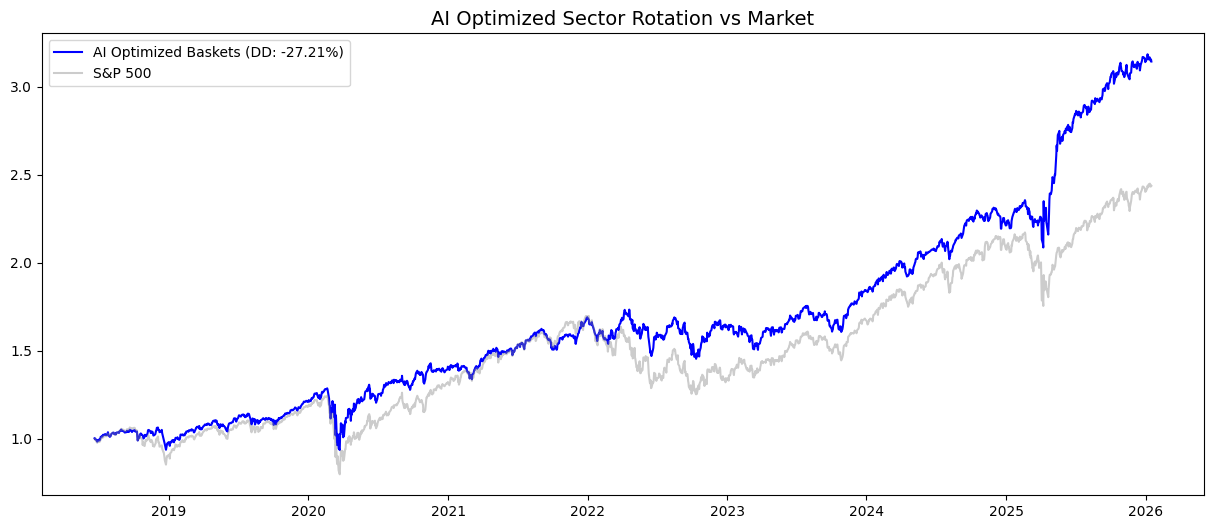

In [93]:
import itertools

# 1. Setup Data
# We use the aligned data from the previous step
all_sectors = ['XLE', 'XLF', 'XLU', 'XLI', 'XLK', 'XLV', 'XLY', 'XLP', 'XLB', 'XLRE', 'XLC']
valid_sectors = [s for s in all_sectors if s in aligned_sectors.columns]

# 2. Define the Optimizer Function
def optimize_regime(regime_label, objective='sharpe'):
    """
    Finds the best sector subset for a specific regime based on the objective.
    """
    # Filter data for ONLY days in this regime
    regime_days = aligned_dataset[aligned_dataset['Regime'] == regime_label].index
    if len(regime_days) == 0:
        return []
    
    subset_data = aligned_sectors.loc[regime_days]
    
    best_score = -999 if objective != 'volatility' else 999
    best_basket = []
    
    # Iterate through ALL possible basket sizes (1 to len(sectors))
    # We limit to max 5 sectors per basket to keep it concentrated/clean (optional)
    for r in range(1, len(valid_sectors) + 1):
        for basket in itertools.combinations(valid_sectors, r):
            basket = list(basket)
            
            # Calculate Equal-Weighted Returns for this basket on these specific days
            basket_returns = subset_data[basket].mean(axis=1)
            
            # Calculate Score
            if objective == 'return':
                score = basket_returns.mean() # Highest average return (least loss in crisis)
            elif objective == 'volatility':
                score = basket_returns.std() # Lowest risk
            elif objective == 'sharpe':
                mu = basket_returns.mean()
                sigma = basket_returns.std()
                score = mu / sigma if sigma > 0 else 0
            
            # Update Best
            if objective == 'volatility':
                if score < best_score:
                    best_score = score
                    best_basket = basket
            else:
                if score > best_score:
                    best_score = score
                    best_basket = basket
                    
    return best_basket, best_score

# 3. Run Optimization for Each Regime
print("Optimizing Regime 0 (Bull) -> Target: Max Sharpe...")
basket_r0, score_r0 = optimize_regime(0, objective='sharpe')

print("Optimizing Regime 1 (Trans) -> Target: Min Volatility...")
# We want stability when the market is unsure
basket_r1, score_r1 = optimize_regime(1, objective='volatility')

print("Optimizing Regime 2 (Crisis) -> Target: Max Return...")
# In a crash, 'Max Return' usually finds the sectors that didn't crash (or went up)
basket_r2, score_r2 = optimize_regime(2, objective='return')

print("\n--- SYSTEM OPTIMIZED BASKETS ---")
print(f"Regime 0 (Bull):   {basket_r0}")
print(f"Regime 1 (Trans):  {basket_r1}")
print(f"Regime 2 (Crisis): {basket_r2}")

# 4. Backtest the "Perfect" Strategy
# Now we run the backtest using these machine-selected baskets
optimized_map = {0: basket_r0, 1: basket_r1, 2: basket_r2}

backtest_opt = pd.DataFrame(index=valid_dates_smooth)
backtest_opt['Regime_Signal'] = smoothed_regimes.shift(1).loc[valid_dates_smooth] # Use Smoothed Signal

opt_returns = []

for date, row in backtest_opt.iterrows():
    signal = row['Regime_Signal']
    if pd.isna(signal):
        opt_returns.append(0.0)
        continue
        
    basket = optimized_map[int(signal)]
    
    # Calculate return
    daily_rets = aligned_sectors_smooth.loc[date, basket].mean()
    opt_returns.append(daily_rets)

backtest_opt['Strategy_Return'] = opt_returns
backtest_opt['SPY_Return'] = aligned_macro_smooth['SPY_Return']

# Stats
backtest_opt['Strategy_Equity'] = (1 + backtest_opt['Strategy_Return']).cumprod()
backtest_opt['SPY_Equity'] = (1 + backtest_opt['SPY_Return']).cumprod()

opt_dd = get_max_drawdown(backtest_opt['Strategy_Equity'])
spy_dd = get_max_drawdown(backtest_opt['SPY_Equity'])

print(f"\nOptimized Drawdown: {opt_dd:.2%}")
print(f"S&P 500 Drawdown:   {spy_dd:.2%}")

# Plot
plt.figure(figsize=(15, 6))
plt.plot(backtest_opt.index, backtest_opt['Strategy_Equity'], label=f'AI Optimized Baskets (DD: {opt_dd:.2%})', color='blue')
plt.plot(backtest_opt.index, backtest_opt['SPY_Equity'], label='S&P 500', color='gray', alpha=0.4)
plt.title('AI Optimized Sector Rotation vs Market', fontsize=14)
plt.legend()
plt.show()

In [94]:
def optimize_regime_with_cash(regime_label, objective='sharpe'):
    # ... (Same setup as before) ...
    regime_days = aligned_dataset[aligned_dataset['Regime'] == regime_label].index
    if len(regime_days) == 0:
        return []
    
    subset_data = aligned_sectors.loc[regime_days]
    
    # Initialize "Best" with CASH (Return=0, Volatility=0)
    # If no stock basket beats this, Cash wins.
    if objective == 'volatility':
        best_score = 0.0 # Cash has 0 vol
        best_basket = ['CASH'] 
    elif objective == 'return':
        best_score = 0.0 # Cash has 0 return
        best_basket = ['CASH']
    else: # Sharpe
        best_score = 0.0
        best_basket = ['CASH']

    # Iterate through baskets as before
    for r in range(1, len(valid_sectors) + 1):
        for basket in itertools.combinations(valid_sectors, r):
            basket = list(basket)
            basket_returns = subset_data[basket].mean(axis=1)
            
            if objective == 'return':
                score = basket_returns.mean()
            elif objective == 'volatility':
                score = basket_returns.std()
            elif objective == 'sharpe':
                mu = basket_returns.mean()
                sigma = basket_returns.std()
                score = mu / sigma if sigma > 0 else 0
            
            # Update Logic
            if objective == 'volatility':
                # For vol, we only switch to stocks if they have LESS risk than Cash (unlikely)
                # But Cash vol is 0, so this usually stays Cash unless we allow small threshold
                if score < best_score: 
                    best_score = score
                    best_basket = basket
            else:
                # For Return/Sharpe, we switch if stocks beat 0
                if score > best_score:
                    best_score = score
                    best_basket = basket
                    
    return best_basket, best_score

print("Re-Optimizing Regime 2 (Crisis) with Cash Option...")
basket_r2, score_r2 = optimize_regime_with_cash(2, objective='return')
print(f"Winner: {basket_r2}")

Re-Optimizing Regime 2 (Crisis) with Cash Option...
Winner: ['CASH']


Re-Optimizing Regime 2 (Crisis) with Cash Option...
Winner for Regime 2: ['CASH']
Average Daily Return during Crisis: 0.00000
Final Max Drawdown: -16.11%


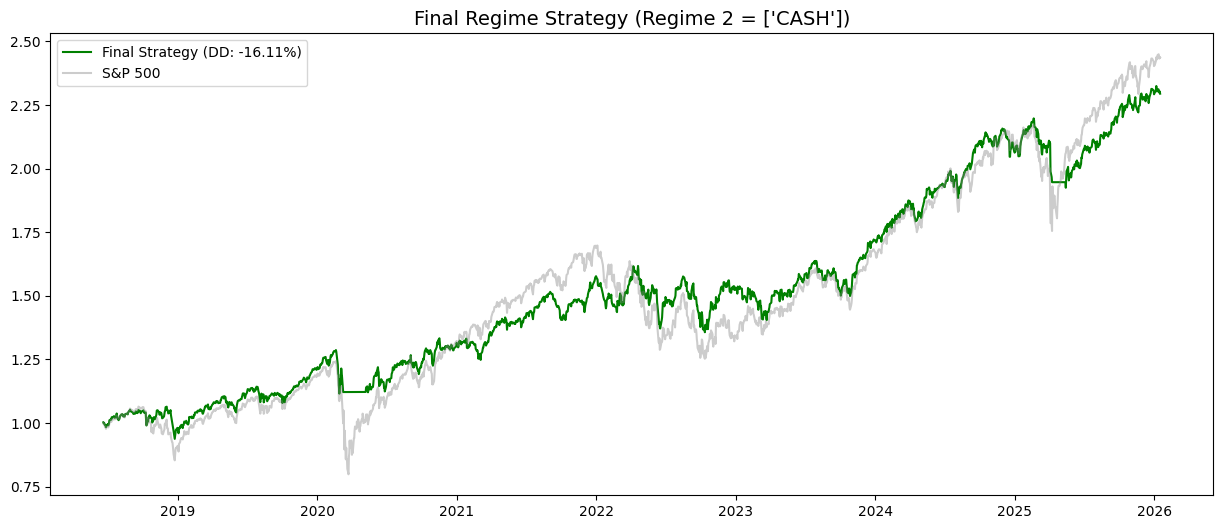

In [95]:
# 1. Update the Optimizer to allow 'CASH'
def optimize_regime_with_cash(regime_label, objective='sharpe'):
    regime_days = aligned_dataset[aligned_dataset['Regime'] == regime_label].index
    if len(regime_days) == 0:
        return [], 0.0
    
    subset_data = aligned_sectors.loc[regime_days]
    
    # Baseline: Cash
    # We assume Cash Return = 0.0 and Cash Volatility = 0.0
    best_basket = ['CASH']
    if objective == 'volatility':
        best_score = 0.0
    elif objective == 'return':
        best_score = 0.0 
    else:
        best_score = 0.0
        
    # Iterate through all stock combinations
    for r in range(1, len(valid_sectors) + 1):
        for basket in itertools.combinations(valid_sectors, r):
            basket = list(basket)
            basket_returns = subset_data[basket].mean(axis=1)
            
            if objective == 'return':
                score = basket_returns.mean()
            elif objective == 'volatility':
                score = basket_returns.std()
            elif objective == 'sharpe':
                mu = basket_returns.mean()
                sigma = basket_returns.std()
                score = mu / sigma if sigma > 0 else 0
            
            # Comparison Logic
            if objective == 'volatility':
                # Only switch to stocks if they are LESS volatile than 0 (impossible, but logic holds)
                if score < best_score: 
                    best_score = score
                    best_basket = basket
            else:
                # For Return, switch if stocks > 0. For Sharpe, switch if score > 0.
                if score > best_score:
                    best_score = score
                    best_basket = basket
                    
    return best_basket, best_score

# 2. Re-Run Optimization for Regime 2
print("Re-Optimizing Regime 2 (Crisis) with Cash Option...")
basket_r2, score_r2 = optimize_regime_with_cash(2, objective='return')

print(f"Winner for Regime 2: {basket_r2}")
print(f"Average Daily Return during Crisis: {score_r2:.5f}")

# 3. Final Backtest with CASH handling
# We use the baskets from previous step for R0 and R1, and new R2
optimized_map = {0: basket_r0, 1: basket_r1, 2: basket_r2}

backtest_final = pd.DataFrame(index=valid_dates_smooth)
backtest_final['Regime_Signal'] = smoothed_regimes.shift(1).loc[valid_dates_smooth]

final_returns = []

for date, row in backtest_final.iterrows():
    signal = row['Regime_Signal']
    if pd.isna(signal):
        final_returns.append(0.0)
        continue
        
    basket = optimized_map[int(signal)]
    
    # HANDLE CASH LOGIC
    if 'CASH' in basket:
        final_returns.append(0.0)
    else:
        daily_rets = aligned_sectors_smooth.loc[date, basket].mean()
        final_returns.append(daily_rets)

backtest_final['Strategy_Return'] = final_returns
backtest_final['SPY_Return'] = aligned_macro_smooth['SPY_Return']

# Stats
backtest_final['Strategy_Equity'] = (1 + backtest_final['Strategy_Return']).cumprod()
backtest_final['SPY_Equity'] = (1 + backtest_final['SPY_Return']).cumprod()

final_dd = get_max_drawdown(backtest_final['Strategy_Equity'])
print(f"Final Max Drawdown: {final_dd:.2%}")

plt.figure(figsize=(15, 6))
plt.plot(backtest_final.index, backtest_final['Strategy_Equity'], label=f'Final Strategy (DD: {final_dd:.2%})', color='green')
plt.plot(backtest_final.index, backtest_final['SPY_Equity'], label='S&P 500', color='gray', alpha=0.4)
plt.title(f'Final Regime Strategy (Regime 2 = {basket_r2})', fontsize=14)
plt.legend()
plt.show()

In [96]:
# --- PRODUCTION: WHAT DO I BUY TODAY? ---

# 1. Get the latest available data point
latest_date = dataset.index[-1]
latest_regime = dataset.loc[latest_date, 'Regime']
latest_vix = dataset.loc[latest_date, 'VIX']

# 2. Define the Final Optimized Map
strategy_map = {
    0: ['XLF', 'XLU', 'XLK', 'XLV', 'XLC'], # Bull
    1: ['XLU', 'XLV', 'XLP'],               # Transition
    2: ['CASH (Treasuries/Money Market)']    # Crisis
}

# 3. Print the Trade Signal
print(f"--- TRADING SIGNAL FOR {latest_date.date()} ---")
print(f"Market State:   Regime {latest_regime} (VIX: {latest_vix:.2f})")
print(f"Recommendation: Buy {strategy_map[int(latest_regime)]}")

# 4. Save the full history for reference
output_file = pd.DataFrame({
    'Regime': dataset['Regime'],
    'Signal_Basket': dataset['Regime'].map(lambda x: str(strategy_map.get(int(x), 'Unknown')))
})
output_file.to_csv('final_strategy_signals.csv')
print("\nFull signal history saved to 'final_strategy_signals.csv'")

--- TRADING SIGNAL FOR 2026-01-16 ---
Market State:   Regime 0 (VIX: 15.86)
Recommendation: Buy ['XLF', 'XLU', 'XLK', 'XLV', 'XLC']

Full signal history saved to 'final_strategy_signals.csv'


                    Total Return Sharpe Ratio Max Drawdown Ann. Volatility
Strategy                                                                  
SPY                      143.71%         0.70      -35.75%          19.60%
Heuristic (Human)        134.20%         0.65      -40.38%          20.73%
AI (Fully Invested)      214.29%         0.92      -27.21%          18.31%
AI (Risk Managed)        129.46%         0.90      -16.11%          13.11%


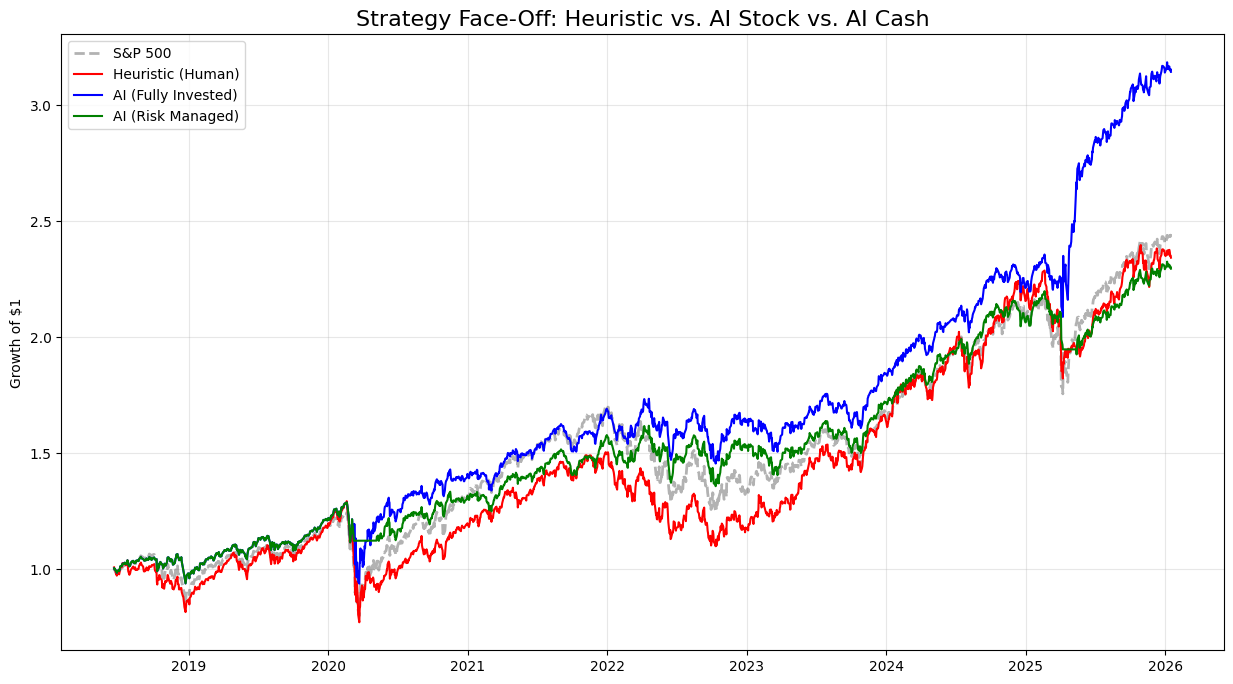

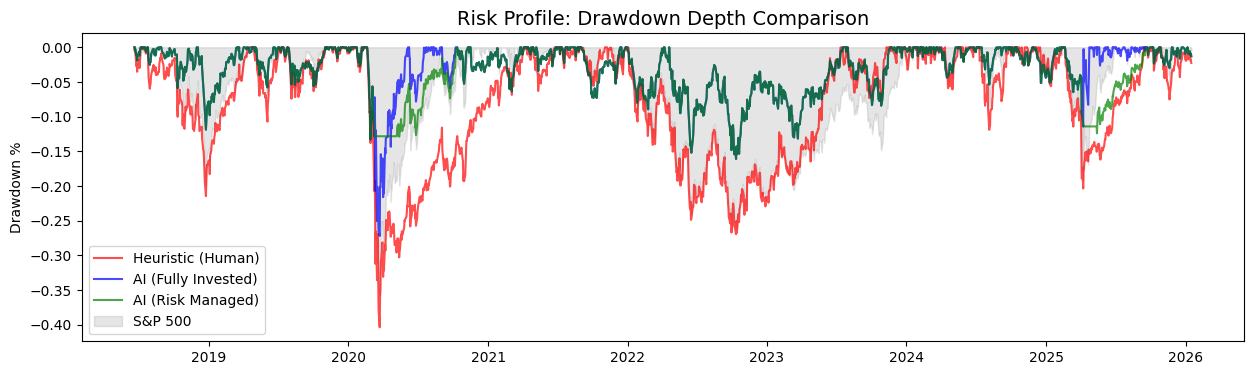

In [98]:
# --- COMPARATIVE ANALYSIS: THE "FACE-OFF" ---

# 1. Define the Three Strategy Maps
# Strategy A: Human Heuristic (Common Wisdom)
strat_heuristic_map = {
    0: ['XLK', 'XLC'],       # Bull -> Aggressive Growth
    1: ['SPY'],              # Uncertainty -> Broad Market
    2: ['XLU', 'XLP']        # Crisis -> Defensives
}

# Strategy B: AI Fully Invested (Stock Only)
# The output from your Step 11 (Risk On)
strat_ai_stock_map = {
    0: ['XLF', 'XLU', 'XLK', 'XLV', 'XLC'], 
    1: ['XLU', 'XLV', 'XLP'],               
    2: ['XLK']                              
}

# Strategy C: AI Risk Managed (With Cash)
# The "Golden" Strategy from Step 12
strat_ai_cash_map = {
    0: ['XLF', 'XLU', 'XLK', 'XLV', 'XLC'], 
    1: ['XLU', 'XLV', 'XLP'],               
    2: ['CASH']                             
}

strategies = {
    "Heuristic (Human)": strat_heuristic_map,
    "AI (Fully Invested)": strat_ai_stock_map,
    "AI (Risk Managed)": strat_ai_cash_map
}

# 2. Run the Multi-Backtest
comparison_results = pd.DataFrame(index=valid_dates_smooth)
comparison_results['SPY'] = aligned_macro_smooth['SPY_Return']

for name, map_dict in strategies.items():
    returns = []
    for date, row in backtest_final.iterrows(): # Using consistent index
        signal = row['Regime_Signal']
        if pd.isna(signal):
            returns.append(0.0)
            continue
            
        basket = map_dict[int(signal)]
        
        # --- FIX STARTS HERE ---
        # We handle CASH, SPY, and Sectors separately
        if 'CASH' in basket:
            returns.append(0.0)
        else:
            daily_basket_rets = []
            for ticker in basket:
                if ticker == 'SPY':
                    # Fetch SPY return from the macro dataframe
                    daily_basket_rets.append(aligned_macro_smooth.loc[date, 'SPY_Return'])
                else:
                    # Fetch Sector return from the sector dataframe
                    daily_basket_rets.append(aligned_sectors_smooth.loc[date, ticker])
            
            # Calculate average return of the basket constituents
            returns.append(np.mean(daily_basket_rets))
        # --- FIX ENDS HERE ---
    
    comparison_results[name] = returns

# 3. Calculate Metrics Table
metrics = []
for col in comparison_results.columns:
    # Cumulative Return
    cum_ret = (1 + comparison_results[col]).cumprod()
    total_ret = cum_ret.iloc[-1] - 1
    
    # Annualized Volatility
    ann_vol = comparison_results[col].std() * np.sqrt(252)
    
    # Sharpe Ratio (Rf=0)
    sharpe = (comparison_results[col].mean() / comparison_results[col].std()) * np.sqrt(252)
    
    # Max Drawdown
    running_max = cum_ret.cummax()
    dd = (cum_ret - running_max) / running_max
    max_dd = dd.min()
    
    metrics.append({
        "Strategy": col,
        "Total Return": f"{total_ret:.2%}",
        "Sharpe Ratio": f"{sharpe:.2f}",
        "Max Drawdown": f"{max_dd:.2%}",
        "Ann. Volatility": f"{ann_vol:.2%}"
    })

metrics_df = pd.DataFrame(metrics).set_index("Strategy")
print(metrics_df)

# 4. Plot Equity Curves
plt.figure(figsize=(15, 8))
# Plot SPY
cum_spy = (1 + comparison_results['SPY']).cumprod()
plt.plot(cum_spy.index, cum_spy, label='S&P 500', color='black', alpha=0.3, linewidth=2, linestyle='--')

# Plot Strategies
colors = ['red', 'blue', 'green']
for i, name in enumerate(strategies.keys()):
    cum_ret = (1 + comparison_results[name]).cumprod()
    plt.plot(cum_ret.index, cum_ret, label=name, color=colors[i], linewidth=1.5)

plt.title('Strategy Face-Off: Heuristic vs. AI Stock vs. AI Cash', fontsize=16)
plt.ylabel('Growth of $1')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# 5. Plot Drawdowns (The Risk View)
plt.figure(figsize=(15, 4))
for i, name in enumerate(strategies.keys()):
    cum_ret = (1 + comparison_results[name]).cumprod()
    running_max = cum_ret.cummax()
    dd = (cum_ret - running_max) / running_max
    plt.plot(dd.index, dd, label=name, color=colors[i], alpha=0.7)

# Plot SPY Drawdown
spy_dd = (cum_spy - cum_spy.cummax()) / cum_spy.cummax()
plt.fill_between(spy_dd.index, spy_dd, color='gray', alpha=0.2, label='S&P 500')

plt.title('Risk Profile: Drawdown Depth Comparison', fontsize=14)
plt.ylabel('Drawdown %')
plt.legend()
plt.show()

In [105]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.cluster.hierarchy as sch
import pandas as pd
import numpy as np
import os

# 1. Setup Directory
os.makedirs('assets', exist_ok=True)
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = [15, 6]

print("Starting Graphic Generation...")

# ==========================================
# FIGURE 1: S&P 500 Colored by Regime
# ==========================================
print("Generating Figure 1 (Regimes)...")
plt.figure(figsize=(15, 6))

# Use SPY Price, aligned with our dataset
spy_price = close_prices['SPY'].loc[dataset.index]
regimes = dataset['Regime']

# Color segments: 0=Bull(Green), 1=Trans(Orange), 2=Crisis(Red)
colors = ['#2ca02c', '#ff7f0e', '#d62728'] 
labels = ['Regime 0 (Bull)', 'Regime 1 (Transition)', 'Regime 2 (Crisis)']

for r in [0, 1, 2]:
    mask = regimes == r
    plt.scatter(dataset.index[mask], spy_price[mask], 
                c=colors[r], s=15, label=labels[r], alpha=0.7)

plt.title('Figure 1: S&P 500 Market Regimes (GMM Detected)', fontsize=16)
plt.ylabel('S&P 500 Price')
plt.legend()
plt.tight_layout()
plt.savefig('assets/fig1.png')
plt.close()

# ==========================================
# FIGURE 2: Dendrograms (Structure)
# ==========================================
print("Generating Figure 2 (Dendrograms)...")
# Requires 'aligned_data' from Step 6
unique_regimes = sorted(aligned_data['Regime'].unique())
fig, axes = plt.subplots(1, 3, figsize=(20, 8))

for i, regime in enumerate(unique_regimes):
    subset = aligned_data[aligned_data['Regime'] == regime].drop(columns=['Regime'])
    corr = subset.corr()
    d = sch.distance.pdist(corr)
    L = sch.linkage(d, method='ward')
    
    ax = axes[i]
    sch.dendrogram(L, labels=corr.columns, leaf_rotation=90, ax=ax)
    ax.set_title(f'Regime {int(regime)} Structure', fontsize=14)
    ax.set_ylabel('Euclidean Distance')
    ax.grid(axis='y', linestyle='--', alpha=0.3)

plt.suptitle('Figure 2: Breakdown of Diversification (Dendrograms)', fontsize=18)
plt.tight_layout()
plt.savefig('assets/fig2.png')
plt.close()

# ==========================================
# INTERMEDIATE: RUN STRATEGY FACE-OFF
# (To ensure we have data for Fig 3, 4, 5)
# ==========================================
print("Simulating Strategies for Figures 3-7...")
strategies = {
    'A: Human Heuristic': {0: ['XLK', 'XLC'], 1: ['SPY'], 2: ['XLU', 'XLP']},
    'B: AI (Aggressive)': {0: ['XLF', 'XLU', 'XLK', 'XLV', 'XLC'], 1: ['XLU', 'XLV', 'XLP'], 2: ['XLK']},
    'C: AI (Safe)':       {0: ['XLF', 'XLU', 'XLK', 'XLV', 'XLC'], 1: ['XLU', 'XLV', 'XLP'], 2: ['CASH']}
}

results_df = pd.DataFrame(index=valid_dates_smooth)
results_df['SPY'] = aligned_macro_smooth['SPY_Return']
signals = smoothed_regimes.shift(1).loc[valid_dates_smooth]

for name, strat_map in strategies.items():
    rets = []
    for date, signal in signals.items():
        if pd.isna(signal):
            rets.append(0.0)
            continue
        basket = strat_map.get(int(signal), [])
        
        if 'CASH' in basket or not basket:
            rets.append(0.0)
        else:
            valid = [t for t in basket if t in aligned_sectors_smooth.columns]
            if valid:
                rets.append(aligned_sectors_smooth.loc[date, valid].mean())
            else:
                rets.append(0.0)
    results_df[name] = rets

equity_df = (1 + results_df).cumprod()

# Calculate Stats
stats = []
for col in equity_df.columns:
    tot = equity_df[col].iloc[-1] - 1
    dd = (equity_df[col] - equity_df[col].cummax()) / equity_df[col].cummax()
    mdd = dd.min()
    stats.append({'Strategy': col, 'Return': tot, 'MaxDD': mdd})
stats_df = pd.DataFrame(stats).set_index('Strategy')

# ==========================================
# FIGURE 3: Equity Curves
# ==========================================
print("Generating Figure 3 (Equity Curves)...")
plt.figure(figsize=(15, 6))
cols = {'C: AI (Safe)': 'green', 'B: AI (Aggressive)': 'blue', 'A: Human Heuristic': 'red', 'SPY': 'gray'}
widths = {'C: AI (Safe)': 2.5, 'B: AI (Aggressive)': 1.5, 'A: Human Heuristic': 1.5, 'SPY': 4}
alphas = {'C: AI (Safe)': 1.0, 'B: AI (Aggressive)': 0.8, 'A: Human Heuristic': 0.8, 'SPY': 0.3}

for col in cols:
    plt.plot(equity_df.index, equity_df[col], color=cols[col], linewidth=widths[col], alpha=alphas[col], label=col)

plt.title('Figure 3: Strategy Face-Off (Equity Curves)', fontsize=16)
plt.ylabel('Cumulative Return ($1 Invested)')
plt.legend()
plt.tight_layout()
plt.savefig('assets/fig3.png')
plt.close()

# ==========================================
# FIGURE 4: Drawdowns
# ==========================================
print("Generating Figure 4 (Drawdowns)...")
plt.figure(figsize=(15, 4))
dd_data = (equity_df - equity_df.cummax()) / equity_df.cummax()

plt.plot(dd_data.index, dd_data['C: AI (Safe)'], color='green', linewidth=2, label='C: AI (Safe)')
plt.plot(dd_data.index, dd_data['SPY'], color='gray', linewidth=1, alpha=0.5, label='S&P 500')
plt.fill_between(dd_data.index, dd_data['SPY'], 0, color='gray', alpha=0.1)

plt.title('Figure 4: Drawdown Depth (Capital Preservation)', fontsize=16)
plt.ylabel('Drawdown %')
plt.legend()
plt.tight_layout()
plt.savefig('assets/fig4.png')
plt.close()

# ==========================================
# FIGURE 5: Risk/Reward Bars
# ==========================================
print("Generating Figure 5 (Risk/Reward)...")
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(stats_df))
width = 0.35

r1 = ax.bar(x - width/2, stats_df['Return']*100, width, label='Total Return %', color='#90EE90', edgecolor='black')
r2 = ax.bar(x + width/2, stats_df['MaxDD']*100, width, label='Max Drawdown %', color='#F08080', edgecolor='black')

ax.set_ylabel('Percentage')
ax.set_title('Figure 5: Risk-Reward Efficiency (Asymmetry)', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(stats_df.index, rotation=15, ha='right')
ax.axhline(0, color='black', linewidth=0.8)
ax.legend()

# Add labels
def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        ax.annotate(f'{h:.1f}%', (rect.get_x() + rect.get_width()/2, h),
                    xytext=(0, 3 if h>0 else -12), textcoords="offset points",
                    ha='center', va='bottom', fontsize=10, fontweight='bold')
autolabel(r1)
autolabel(r2)

plt.tight_layout()
plt.savefig('assets/fig5.png') # Referred to as risk_reward_bars.png in report
plt.close()

# ==========================================
# FIGURE 6: 2020 Zoom
# ==========================================
print("Generating Figure 6 (2020 Zoom)...")
z20 = equity_df.loc['2020-01-01':'2020-06-30']
plt.figure(figsize=(10, 5))
plt.plot(z20.index, z20['C: AI (Safe)'], color='green', linewidth=2.5, label='AI Safe Strategy')
plt.plot(z20.index, z20['SPY'], color='gray', alpha=0.5, linewidth=2, label='S&P 500')
plt.title('Figure 6: COVID-19 Crash Performance (2020)', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('assets/fig6.png')
plt.close()

# ==========================================
# FIGURE 7: 2022 Zoom
# ==========================================
print("Generating Figure 7 (2022 Zoom)...")
z22 = equity_df.loc['2022-01-01':'2022-12-31']
plt.figure(figsize=(10, 5))
plt.plot(z22.index, z22['C: AI (Safe)'], color='green', linewidth=2.5, label='AI Safe Strategy')
plt.plot(z22.index, z22['SPY'], color='gray', alpha=0.5, linewidth=2, label='S&P 500')
plt.title('Figure 7: Inflation Bear Market Performance (2022)', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('assets/fig7.png')
plt.close()

print("SUCCESS: All 7 figures saved to 'assets/' folder.")

Starting Graphic Generation...
Generating Figure 1 (Regimes)...
Generating Figure 2 (Dendrograms)...
Simulating Strategies for Figures 3-7...
Generating Figure 3 (Equity Curves)...
Generating Figure 4 (Drawdowns)...
Generating Figure 5 (Risk/Reward)...
Generating Figure 6 (2020 Zoom)...
Generating Figure 7 (2022 Zoom)...
SUCCESS: All 7 figures saved to 'assets/' folder.
